# SSD7 Training Tutorial

This tutorial explains how to train an SSD7 on the Udacity road traffic datasets, and just generally how to use this SSD implementation.

Disclaimer about SSD7:
As you will see below, training SSD7 on the aforementioned datasets yields alright results, but I'd like to emphasize that SSD7 is not a carefully optimized network architecture. The idea was just to build a low-complexity network that is fast (roughly 127 FPS or more than 3 times as fast as SSD300 on a GTX 1070) for testing purposes. Would slightly different anchor box scaling factors or a slightly different number of filters in individual convolution layers make SSD7 significantly better at similar complexity? I don't know, I haven't tried.

In [1]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

%matplotlib inline

Using TensorFlow backend.


## 1. Set the model configuration parameters

The cell below sets a number of parameters that define the model configuration. The parameters set here are being used both by the `build_model()` function that builds the model as well as further down by the constructor for the `SSDInputEncoder` object that is needed to match ground truth and anchor boxes during the training.

Here are just some comments on a few of the parameters, read the documentation for more details:

* Set the height, width, and number of color channels to whatever you want the model to accept as image input. If your input images have a different size than you define as the model input here, or if your images have non-uniform size, then you must use the data generator's image transformations (resizing and/or cropping) so that your images end up having the required input size before they are fed to the model. to convert your images to the model input size during training. The SSD300 training tutorial uses the same image pre-processing and data augmentation as the original Caffe implementation, so take a look at that to see one possibility of how to deal with non-uniform-size images.


* The number of classes is the number of positive classes in your dataset, e.g. 20 for Pascal VOC or 80 for MS COCO. Class ID 0 must always be reserved for the background class, i.e. your positive classes must have positive integers as their IDs in your dataset.


* The `mode` argument in the `build_model()` function determines whether the model will be built with or without a `DecodeDetections` layer as its last layer. In 'training' mode, the model outputs the raw prediction tensor, while in 'inference' and 'inference_fast' modes, the raw predictions are being decoded into absolute coordinates and filtered via confidence thresholding, non-maximum suppression, and top-k filtering(上位k件だけ取り出すこと). The difference between latter two modes is that 'inference' uses the decoding procedure of the original Caffe implementation, while 'inference_fast' uses a faster, but possibly less accurate decoding procedure.


* The reason why the list of scaling factors has 5 elements even though there are only 4 predictor layers in SSD7 is that the last scaling factor is used for the second aspect-ratio-1 box of the last predictor layer. Refer to the documentation for details.


* `build_model()` and `SSDInputEncoder` have two arguments for the anchor box aspect ratios: `aspect_ratios_global` and `aspect_ratios_per_layer`. You can use either of the two, you don't need to set both. If you use `aspect_ratios_global`, then you pass one list of aspect ratios and these aspect ratios will be used for all predictor layers. Every aspect ratio you want to include must be listed once and only once. If you use `aspect_ratios_per_layer`, then you pass a nested list containing lists of aspect ratios for each individual predictor layer. This is what the SSD300 training tutorial does. It's your design choice whether all predictor layers should use the same aspect ratios or whether you think that for your dataset, certain aspect ratios are only necessary for some predictor layers but not for others. Of course more aspect ratios means more predicted boxes, which in turn means increased computational complexity. (aspect_ratioを全体で同じの使っても良いしlayer毎に変えても良いけどlayer毎に変えた方が複雑になって計算コスト増えるよー、というおはなし)


* If `two_boxes_for_ar1 == True`, then each predictor layer will predict two boxes with aspect ratio one, one a bit smaller, the other one a bit larger.


* If `clip_boxes == True`, then the anchor boxes will be clipped so that they lie entirely within the image boundaries. It is recommended not to clip the boxes. The anchor boxes form the reference frame for the localization prediction. This reference frame should be the same at every spatial position. (意味不明)


* In the matching process during the training, the anchor box offsets are being divided by the variances. Leaving them at 1.0 for each of the four box coordinates means that they have no effect. Setting them to less than 1.0 spreads the imagined anchor box offset distribution for the respective box coordinate.


* `normalize_coords` converts all coordinates from absolute coordinate to coordinates that are relative to the image height and width. This setting has no effect on the outcome of the training.

In [2]:
img_height = 300 # Height of the input images
img_width = 480 # Width of the input images
img_channels = 3 # Number of color channels of the input images
intensity_mean = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
intensity_range = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
n_classes = 5 # Number of positive classes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size

## 2. Build or load the model

You will want to execute either of the two code cells in the subsequent two sub-sections, not both.

### 2.1 Create a new model

If you want to create a new model, this is the relevant section for you. If you want to load a previously saved model, skip ahead to section 2.2.

The code cell below does the following things:
1. It calls the function `build_model()` to build the model.
2. It optionally loads some weights into the model.
3. It then compiles the model for the training. In order to do so, we're defining an optimizer (Adam) and a loss function (SSDLoss) to be passed to the `compile()` method.

`SSDLoss` is a custom Keras loss function that implements the multi-task log loss for classification and smooth L1 loss for localization. `neg_pos_ratio` and `alpha` are set as in the paper.

In [3]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

# 2: Optional: Load some weights

#model.load_weights('./ssd7_weights.h5', by_name=True)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

### 2.2 Load a saved model

If you have previously created and saved a model and would now like to load it, simply execute the next code cell. The only thing you need to do is to set the path to the saved model HDF5 file that you would like to load.

The SSD model contains custom objects: Neither the loss function, nor the anchor box or detection decoding layer types are contained in the Keras core library, so we need to provide them to the model loader.

This next code cell assumes that you want to load a model that was created in 'training' mode. If you want to load a model that was created in 'inference' or 'inference_fast' mode, you'll have to add the `DecodeDetections` or `DecodeDetectionsFast` layer type to the `custom_objects` dictionary below.

In [ ]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'ssd7.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'compute_loss': ssd_loss.compute_loss})

## 3. Set up the data generators for the training

The code cells below set up data generators for the training and validation datasets to train the model. You will have to set the file paths to your dataset. Depending on the annotations format of your dataset, you might also have to switch from the CSV parser to the XML or JSON parser, or you might have to write a new parser method in the `DataGenerator` class that can handle whatever format your annotations are in. The [README](https://github.com/pierluigiferrari/ssd_keras/blob/master/README.md) of this repository provides a summary of the design of the `DataGenerator`, which should help you in case you need to write a new parser or adapt one of the existing parsers to your needs.

Note that the generator provides two options to speed up the training. By default, it loads the individual images for a batch from disk. This has two disadvantages. 

1. First, for compressed image formats like JPG, this is a huge computational waste, because every image needs to be decompressed again and again every time it is being loaded. 
(jpgみたいな圧縮ファイルは読み込むたびに解凍が必要になるから無駄、一度解凍したらそれ使いまわせよ！というはなし)

2. Second, the images on disk are likely not stored in a contiguous block of memory, which may also slow down the loading process. 
(ディスク上にある画像はメモリ内で隣同士に保存されてるわけじゃないんだから毎回探すのも時間の無駄)

The first option that `DataGenerator` provides to deal with this is to load the entire dataset into memory, which reduces the access time for any image to a negligible amount, but of course this is only an option if you have enough free memory to hold the whole dataset. As a second option, `DataGenerator` provides the possibility to convert the dataset into a single HDF5 file. This HDF5 file stores the images as uncompressed arrays in a contiguous block of memory, which dramatically speeds up the loading time. It's not as good as having the images in memory, but it's a lot better than the default option of loading them from their compressed JPG state every time they are needed. Of course such an HDF5 dataset may require significantly more disk space than the compressed images. You can later load these HDF5 datasets directly in the constructor. (全部まとめてロードするか、全画像をhdf5形式に変換してからロードするか。)

Set the batch size to your preference and to what your GPU memory allows, it's not the most important hyperparameter. The Caffe implementation uses a batch size of 32, but smaller batch sizes work fine, too.

The `DataGenerator` itself is fairly generic. I doesn't contain any data augmentation or bounding box encoding logic. Instead, you pass a list of image transformations and an encoder for the bounding boxes in the `transformations` and `label_encoder` arguments of the data generator's `generate()` method, and the data generator will then apply those given transformations and the encoding to the data. Everything here is preset already, but if you'd like to learn more about the data generator and its data augmentation capabilities, take a look at the detailed tutorial in [this](https://github.com/pierluigiferrari/data_generator_object_detection_2d) repository.

The image processing chain defined further down in the object named `data_augmentation_chain` is just one possibility of what a data augmentation pipeline for unform-size images could look like. Feel free to put together other image processing chains, you can use the `DataAugmentationConstantInputSize` class as a template. Or you could use the original SSD data augmentation pipeline by instantiting an `SSDDataAugmentation` object and passing that to the generator instead. This procedure is not exactly efficient, but it evidently produces good results on multiple datasets.

An `SSDInputEncoder` object, `ssd_input_encoder`, is passed to both the training and validation generators. As explained above, it matches the ground truth labels to the model's anchor boxes and encodes the box coordinates into the format that the model needs.

### Note:

The example setup below was used to train SSD7 on two road traffic datasets released by [Udacity](https://github.com/udacity/self-driving-car/tree/master/annotations) with around 20,000 images in total and 5 object classes (car, truck, pedestrian, bicyclist, traffic light), although the vast majority of the objects are cars. The original datasets have a constant image size of 1200x1920 RGB. I consolidated the two datasets, removed a few bad samples (although there are probably many more), and resized the images to 300x480 RGB, i.e. to one sixteenth of the original image size. In case you'd like to train a model on the same dataset, you can download the consolidated and resized dataset I used [here](https://drive.google.com/open?id=1tfBFavijh4UTG4cGqIKwhcklLXUDuY0D) (about 900 MB).

In [4]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Images
images_dir = '../Dataset/udacity_driving_datasets/'

# Ground truth
train_labels_filename = '../Dataset/udacity_driving_datasets/labels_train.csv'
val_labels_filename   = '../Dataset/udacity_driving_datasets/labels_val.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.

train_dataset.create_hdf5_dataset(file_path='dataset_udacity_traffic_train.h5',
                                  resize=False,
                                  variable_image_size=True,
                                  verbose=True)

val_dataset.create_hdf5_dataset(file_path='dataset_udacity_traffic_val.h5',
                                resize=False,
                                variable_image_size=True,
                                verbose=True)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Creating HDF5 dataset: 100%|███████████████| 4241/4241 [00:53<00:00, 78.61it/s]
Number of images in the training dataset:	 18000
Number of images in the validation dataset:	  4241


In [26]:
# 3: Set the batch size.

batch_size = 8

# 4: Define the image processing chain.

data_augmentation_chain = DataAugmentationConstantInputSize(random_brightness=(-48, 48, 0.5),
                                                            random_contrast=(0.5, 1.8, 0.5),
                                                            random_saturation=(0.5, 1.8, 0.5),
                                                            random_hue=(18, 0.5),
                                                            random_flip=0.5,
                                                            random_translate=((0.03,0.5), (0.03,0.5), 0.5),
                                                            random_scale=(0.5, 2.0, 0.5),
                                                            n_trials_max=3,
                                                            clip_boxes=True,
                                                            overlap_criterion='area',
                                                            bounds_box_filter=(0.3, 1.0),
                                                            bounds_validator=(0.5, 1.0),
                                                            n_boxes_min=1,
                                                            background=(0,0,0))

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_global=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[data_augmentation_chain],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

## 4. Set the remaining training parameters and train the model

We've already chosen an optimizer and a learning rate and set the batch size above, now let's set the remaining training parameters.

I'll set a few Keras callbacks below, one for early stopping, one to reduce the learning rate if the training stagnates, one to save the best models during the training, and one to continuously stream the training history to a CSV file after every epoch. Logging to a CSV file makes sense, because if we didn't do that, in case the training terminates with an exception at some point or if the kernel of this Jupyter notebook dies for some reason or anything like that happens, we would lose the entire history for the trained epochs. Feel free to add more callbacks if you want TensorBoard summaries or whatever.

In [27]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the weights.
model_checkpoint = ModelCheckpoint(filepath='../Model/SSD-keras/ssd7_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename='ssd7_training_log.csv',
                       separator=',',
                       append=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=8,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)

callbacks = [model_checkpoint,
             csv_logger,
             early_stopping,
             reduce_learning_rate]

C:\Users\uidp4921\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\keras\callbacks.py:928: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.
  warnings.warn('`epsilon` argument is deprecated and '


I'll set one epoch to consist of 1,000 training steps I'll arbitrarily set the number of epochs to 20 here. This does not imply that 20,000 training steps is the right number. Depending on the model, the dataset, the learning rate, etc. you might have to train much longer to achieve convergence, or maybe less.

Instead of trying to train a model to convergence in one go, you might want to train only for a few epochs at a time.

In order to only run a partial training and resume smoothly later on, there are a few things you should note:
1. Always load the full model if you can, rather than building a new model and loading previously saved weights into it. Optimizers like SGD or Adam keep running averages of past gradient moments internally. If you always save and load full models when resuming a training, then the state of the optimizer is maintained and the training picks up exactly where it left off. If you build a new model and load weights into it, the optimizer is being initialized from scratch, which, especially in the case of Adam, leads to small but unnecessary setbacks every time you resume the training with previously saved weights.
2. You should tell `fit_generator()` which epoch to start from, otherwise it will start with epoch 0 every time you resume the training. Set `initial_epoch` to be the next epoch of your training. Note that this parameter is zero-based, i.e. the first epoch is epoch 0. If you had trained for 10 epochs previously and now you'd want to resume the training from there, you'd set `initial_epoch = 10` (since epoch 10 is the eleventh epoch). Furthermore, set `final_epoch` to the last epoch you want to run. To stick with the previous example, if you had trained for 10 epochs previously and now you'd want to train for another 10 epochs, you'd set `initial_epoch = 10` and `final_epoch = 20`.
3. Callbacks like `ModelCheckpoint` or `ReduceLROnPlateau` are stateful, so you might want ot save their state somehow if you want to pick up a training exactly where you left off.

In [28]:
# TODO: Set the epochs to train for.
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 20
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 1/20


 313/1000 [========>.....................] - ETA: 38:55 - loss: 2.96 - ETA: 22:38 - loss: 3.02 - ETA: 17:10 - loss: 3.13 - ETA: 14:25 - loss: 3.09 - ETA: 13:31 - loss: 3.07 - ETA: 13:12 - loss: 3.05 - ETA: 12:57 - loss: 3.04 - ETA: 12:51 - loss: 3.05 - ETA: 12:48 - loss: 3.00 - ETA: 12:27 - loss: 3.01 - ETA: 12:19 - loss: 3.02 - ETA: 12:09 - loss: 3.02 - ETA: 11:59 - loss: 2.99 - ETA: 12:02 - loss: 2.98 - ETA: 12:01 - loss: 3.01 - ETA: 11:58 - loss: 3.00 - ETA: 11:54 - loss: 2.98 - ETA: 11:52 - loss: 2.99 - ETA: 11:48 - loss: 2.98 - ETA: 11:44 - loss: 2.98 - ETA: 11:42 - loss: 2.97 - ETA: 11:45 - loss: 2.97 - ETA: 11:40 - loss: 2.98 - ETA: 11:35 - loss: 2.97 - ETA: 11:34 - loss: 2.95 - ETA: 11:33 - loss: 2.95 - ETA: 11:31 - loss: 2.96 - ETA: 11:29 - loss: 2.96 - ETA: 11:28 - loss: 2.95 - ETA: 11:27 - loss: 2.96 - ETA: 11:23 - loss: 2.96 - ETA: 11:22 - loss: 2.96 - ETA: 11:23 - loss: 2.95 - ETA: 11:22 - loss: 2.95 - ETA: 11:19 - loss: 2.94 - ETA: 11:19 - loss: 2.93 - ETA: 11:19 - loss: 

 627/1000 [=================>............] - ETA: 8:19 - loss: 2.725 - ETA: 8:19 - loss: 2.723 - ETA: 8:18 - loss: 2.722 - ETA: 8:17 - loss: 2.723 - ETA: 8:16 - loss: 2.723 - ETA: 8:15 - loss: 2.723 - ETA: 8:15 - loss: 2.724 - ETA: 8:14 - loss: 2.723 - ETA: 8:13 - loss: 2.724 - ETA: 8:13 - loss: 2.723 - ETA: 8:12 - loss: 2.722 - ETA: 8:11 - loss: 2.722 - ETA: 8:11 - loss: 2.722 - ETA: 8:10 - loss: 2.722 - ETA: 8:09 - loss: 2.722 - ETA: 8:08 - loss: 2.722 - ETA: 8:07 - loss: 2.722 - ETA: 8:06 - loss: 2.722 - ETA: 8:06 - loss: 2.723 - ETA: 8:05 - loss: 2.724 - ETA: 8:04 - loss: 2.723 - ETA: 8:03 - loss: 2.722 - ETA: 8:03 - loss: 2.721 - ETA: 8:02 - loss: 2.721 - ETA: 8:02 - loss: 2.721 - ETA: 8:01 - loss: 2.720 - ETA: 8:00 - loss: 2.721 - ETA: 7:59 - loss: 2.720 - ETA: 7:59 - loss: 2.720 - ETA: 7:58 - loss: 2.720 - ETA: 7:57 - loss: 2.721 - ETA: 7:56 - loss: 2.719 - ETA: 7:56 - loss: 2.720 - ETA: 7:55 - loss: 2.720 - ETA: 7:54 - loss: 2.720 - ETA: 7:54 - loss: 2.720 - ETA: 7:53 - loss: 2

 943/1000 [===========================>..] - ETA: 4:35 - loss: 2.689 - ETA: 4:34 - loss: 2.688 - ETA: 4:34 - loss: 2.688 - ETA: 4:33 - loss: 2.688 - ETA: 4:32 - loss: 2.687 - ETA: 4:31 - loss: 2.686 - ETA: 4:31 - loss: 2.686 - ETA: 4:30 - loss: 2.685 - ETA: 4:29 - loss: 2.685 - ETA: 4:28 - loss: 2.685 - ETA: 4:28 - loss: 2.684 - ETA: 4:27 - loss: 2.685 - ETA: 4:26 - loss: 2.685 - ETA: 4:25 - loss: 2.685 - ETA: 4:24 - loss: 2.684 - ETA: 4:24 - loss: 2.684 - ETA: 4:23 - loss: 2.684 - ETA: 4:22 - loss: 2.684 - ETA: 4:21 - loss: 2.684 - ETA: 4:21 - loss: 2.684 - ETA: 4:20 - loss: 2.684 - ETA: 4:19 - loss: 2.683 - ETA: 4:18 - loss: 2.682 - ETA: 4:18 - loss: 2.683 - ETA: 4:17 - loss: 2.683 - ETA: 4:16 - loss: 2.683 - ETA: 4:15 - loss: 2.683 - ETA: 4:15 - loss: 2.683 - ETA: 4:14 - loss: 2.683 - ETA: 4:13 - loss: 2.683 - ETA: 4:13 - loss: 2.683 - ETA: 4:12 - loss: 2.682 - ETA: 4:11 - loss: 2.682 - ETA: 4:10 - loss: 2.681 - ETA: 4:10 - loss: 2.681 - ETA: 4:09 - loss: 2.681 - ETA: 4:08 - loss: 2

1000/1000 [==============================] - ETA: 41s - loss: 2.65 - ETA: 40s - loss: 2.65 - ETA: 39s - loss: 2.65 - ETA: 39s - loss: 2.65 - ETA: 38s - loss: 2.65 - ETA: 37s - loss: 2.65 - ETA: 36s - loss: 2.65 - ETA: 36s - loss: 2.65 - ETA: 35s - loss: 2.65 - ETA: 34s - loss: 2.65 - ETA: 33s - loss: 2.65 - ETA: 33s - loss: 2.65 - ETA: 32s - loss: 2.65 - ETA: 31s - loss: 2.65 - ETA: 30s - loss: 2.65 - ETA: 30s - loss: 2.65 - ETA: 29s - loss: 2.65 - ETA: 28s - loss: 2.65 - ETA: 27s - loss: 2.65 - ETA: 27s - loss: 2.65 - ETA: 26s - loss: 2.65 - ETA: 25s - loss: 2.65 - ETA: 25s - loss: 2.65 - ETA: 24s - loss: 2.65 - ETA: 23s - loss: 2.65 - ETA: 22s - loss: 2.65 - ETA: 22s - loss: 2.65 - ETA: 21s - loss: 2.65 - ETA: 20s - loss: 2.65 - ETA: 19s - loss: 2.65 - ETA: 19s - loss: 2.65 - ETA: 18s - loss: 2.65 - ETA: 17s - loss: 2.65 - ETA: 16s - loss: 2.65 - ETA: 16s - loss: 2.65 - ETA: 15s - loss: 2.65 - ETA: 14s - loss: 2.65 - ETA: 13s - loss: 2.65 - ETA: 13s - loss: 2.65 - ETA: 12s - loss: 2.

 314/1000 [========>.....................] - ETA: 6:42 - loss: 2.903 - ETA: 6:35 - loss: 2.894 - ETA: 7:03 - loss: 2.867 - ETA: 6:51 - loss: 2.836 - ETA: 6:44 - loss: 2.824 - ETA: 6:40 - loss: 2.790 - ETA: 6:37 - loss: 2.757 - ETA: 6:37 - loss: 2.670 - ETA: 6:38 - loss: 2.692 - ETA: 6:48 - loss: 2.652 - ETA: 6:44 - loss: 2.673 - ETA: 6:41 - loss: 2.650 - ETA: 6:39 - loss: 2.629 - ETA: 6:36 - loss: 2.602 - ETA: 6:34 - loss: 2.601 - ETA: 6:33 - loss: 2.584 - ETA: 6:31 - loss: 2.610 - ETA: 6:30 - loss: 2.609 - ETA: 6:28 - loss: 2.594 - ETA: 6:27 - loss: 2.597 - ETA: 6:33 - loss: 2.601 - ETA: 6:50 - loss: 2.597 - ETA: 7:04 - loss: 2.588 - ETA: 7:12 - loss: 2.576 - ETA: 7:21 - loss: 2.578 - ETA: 7:32 - loss: 2.567 - ETA: 7:38 - loss: 2.567 - ETA: 7:47 - loss: 2.565 - ETA: 7:55 - loss: 2.552 - ETA: 8:03 - loss: 2.557 - ETA: 8:11 - loss: 2.562 - ETA: 8:18 - loss: 2.577 - ETA: 8:21 - loss: 2.580 - ETA: 8:27 - loss: 2.582 - ETA: 8:34 - loss: 2.574 - ETA: 8:37 - loss: 2.576 - ETA: 8:45 - loss: 2

 628/1000 [=================>............] - ETA: 8:01 - loss: 2.551 - ETA: 8:00 - loss: 2.551 - ETA: 8:00 - loss: 2.550 - ETA: 7:59 - loss: 2.550 - ETA: 7:58 - loss: 2.550 - ETA: 7:58 - loss: 2.549 - ETA: 7:57 - loss: 2.549 - ETA: 7:56 - loss: 2.549 - ETA: 7:55 - loss: 2.549 - ETA: 7:55 - loss: 2.549 - ETA: 7:54 - loss: 2.549 - ETA: 7:54 - loss: 2.549 - ETA: 7:53 - loss: 2.550 - ETA: 7:52 - loss: 2.549 - ETA: 7:52 - loss: 2.550 - ETA: 7:51 - loss: 2.550 - ETA: 7:51 - loss: 2.550 - ETA: 7:50 - loss: 2.549 - ETA: 7:49 - loss: 2.550 - ETA: 7:49 - loss: 2.549 - ETA: 7:48 - loss: 2.549 - ETA: 7:47 - loss: 2.549 - ETA: 7:47 - loss: 2.551 - ETA: 7:46 - loss: 2.551 - ETA: 7:45 - loss: 2.551 - ETA: 7:45 - loss: 2.551 - ETA: 7:44 - loss: 2.551 - ETA: 7:44 - loss: 2.550 - ETA: 7:43 - loss: 2.551 - ETA: 7:43 - loss: 2.551 - ETA: 7:42 - loss: 2.553 - ETA: 7:42 - loss: 2.552 - ETA: 7:41 - loss: 2.552 - ETA: 7:40 - loss: 2.554 - ETA: 7:39 - loss: 2.553 - ETA: 7:39 - loss: 2.552 - ETA: 7:38 - loss: 2

 944/1000 [===========================>..] - ETA: 4:27 - loss: 2.552 - ETA: 4:27 - loss: 2.553 - ETA: 4:26 - loss: 2.553 - ETA: 4:25 - loss: 2.553 - ETA: 4:25 - loss: 2.553 - ETA: 4:24 - loss: 2.553 - ETA: 4:23 - loss: 2.554 - ETA: 4:23 - loss: 2.554 - ETA: 4:22 - loss: 2.554 - ETA: 4:21 - loss: 2.554 - ETA: 4:20 - loss: 2.554 - ETA: 4:20 - loss: 2.554 - ETA: 4:19 - loss: 2.554 - ETA: 4:18 - loss: 2.554 - ETA: 4:17 - loss: 2.555 - ETA: 4:17 - loss: 2.555 - ETA: 4:16 - loss: 2.556 - ETA: 4:15 - loss: 2.556 - ETA: 4:15 - loss: 2.557 - ETA: 4:14 - loss: 2.557 - ETA: 4:13 - loss: 2.556 - ETA: 4:12 - loss: 2.556 - ETA: 4:12 - loss: 2.556 - ETA: 4:11 - loss: 2.556 - ETA: 4:10 - loss: 2.555 - ETA: 4:10 - loss: 2.556 - ETA: 4:09 - loss: 2.555 - ETA: 4:08 - loss: 2.555 - ETA: 4:08 - loss: 2.554 - ETA: 4:07 - loss: 2.554 - ETA: 4:06 - loss: 2.553 - ETA: 4:05 - loss: 2.553 - ETA: 4:05 - loss: 2.553 - ETA: 4:04 - loss: 2.554 - ETA: 4:03 - loss: 2.554 - ETA: 4:03 - loss: 2.554 - ETA: 4:02 - loss: 2

1000/1000 [==============================] - ETA: 39s - loss: 2.55 - ETA: 39s - loss: 2.55 - ETA: 38s - loss: 2.55 - ETA: 37s - loss: 2.55 - ETA: 36s - loss: 2.55 - ETA: 36s - loss: 2.55 - ETA: 35s - loss: 2.55 - ETA: 34s - loss: 2.55 - ETA: 33s - loss: 2.55 - ETA: 33s - loss: 2.55 - ETA: 32s - loss: 2.55 - ETA: 31s - loss: 2.55 - ETA: 31s - loss: 2.55 - ETA: 30s - loss: 2.55 - ETA: 29s - loss: 2.55 - ETA: 28s - loss: 2.55 - ETA: 28s - loss: 2.55 - ETA: 27s - loss: 2.55 - ETA: 26s - loss: 2.55 - ETA: 26s - loss: 2.55 - ETA: 25s - loss: 2.55 - ETA: 24s - loss: 2.55 - ETA: 23s - loss: 2.55 - ETA: 23s - loss: 2.55 - ETA: 22s - loss: 2.55 - ETA: 21s - loss: 2.55 - ETA: 21s - loss: 2.55 - ETA: 20s - loss: 2.55 - ETA: 19s - loss: 2.55 - ETA: 18s - loss: 2.55 - ETA: 18s - loss: 2.55 - ETA: 17s - loss: 2.55 - ETA: 16s - loss: 2.55 - ETA: 15s - loss: 2.55 - ETA: 15s - loss: 2.55 - ETA: 14s - loss: 2.55 - ETA: 13s - loss: 2.55 - ETA: 13s - loss: 2.55 - ETA: 12s - loss: 2.55 - ETA: 11s - loss: 2.

 314/1000 [========>.....................] - ETA: 8:09 - loss: 2.615 - ETA: 7:13 - loss: 2.761 - ETA: 7:10 - loss: 2.742 - ETA: 6:57 - loss: 2.638 - ETA: 6:49 - loss: 2.542 - ETA: 6:44 - loss: 2.628 - ETA: 6:45 - loss: 2.545 - ETA: 6:43 - loss: 2.600 - ETA: 6:41 - loss: 2.590 - ETA: 6:38 - loss: 2.574 - ETA: 6:36 - loss: 2.578 - ETA: 6:34 - loss: 2.566 - ETA: 6:32 - loss: 2.535 - ETA: 6:31 - loss: 2.521 - ETA: 6:29 - loss: 2.496 - ETA: 6:28 - loss: 2.513 - ETA: 6:28 - loss: 2.505 - ETA: 6:31 - loss: 2.481 - ETA: 6:30 - loss: 2.482 - ETA: 6:29 - loss: 2.492 - ETA: 6:38 - loss: 2.519 - ETA: 6:49 - loss: 2.529 - ETA: 7:00 - loss: 2.517 - ETA: 7:09 - loss: 2.519 - ETA: 7:20 - loss: 2.519 - ETA: 7:33 - loss: 2.522 - ETA: 7:46 - loss: 2.521 - ETA: 7:53 - loss: 2.510 - ETA: 8:00 - loss: 2.511 - ETA: 8:04 - loss: 2.502 - ETA: 8:19 - loss: 2.503 - ETA: 8:26 - loss: 2.499 - ETA: 8:31 - loss: 2.495 - ETA: 8:35 - loss: 2.493 - ETA: 8:42 - loss: 2.496 - ETA: 8:43 - loss: 2.488 - ETA: 8:47 - loss: 2

 628/1000 [=================>............] - ETA: 8:03 - loss: 2.550 - ETA: 8:02 - loss: 2.550 - ETA: 8:01 - loss: 2.549 - ETA: 8:00 - loss: 2.548 - ETA: 7:59 - loss: 2.548 - ETA: 7:59 - loss: 2.547 - ETA: 7:58 - loss: 2.546 - ETA: 7:57 - loss: 2.547 - ETA: 7:56 - loss: 2.547 - ETA: 7:55 - loss: 2.547 - ETA: 7:55 - loss: 2.546 - ETA: 7:54 - loss: 2.545 - ETA: 7:53 - loss: 2.545 - ETA: 7:52 - loss: 2.544 - ETA: 7:51 - loss: 2.546 - ETA: 7:51 - loss: 2.546 - ETA: 7:50 - loss: 2.546 - ETA: 7:49 - loss: 2.545 - ETA: 7:49 - loss: 2.545 - ETA: 7:48 - loss: 2.544 - ETA: 7:47 - loss: 2.543 - ETA: 7:46 - loss: 2.543 - ETA: 7:46 - loss: 2.542 - ETA: 7:45 - loss: 2.542 - ETA: 7:44 - loss: 2.543 - ETA: 7:43 - loss: 2.542 - ETA: 7:42 - loss: 2.541 - ETA: 7:42 - loss: 2.543 - ETA: 7:41 - loss: 2.544 - ETA: 7:41 - loss: 2.545 - ETA: 7:40 - loss: 2.545 - ETA: 7:39 - loss: 2.544 - ETA: 7:38 - loss: 2.544 - ETA: 7:37 - loss: 2.544 - ETA: 7:36 - loss: 2.543 - ETA: 7:36 - loss: 2.541 - ETA: 7:35 - loss: 2

 944/1000 [===========================>..] - ETA: 4:20 - loss: 2.518 - ETA: 4:19 - loss: 2.518 - ETA: 4:19 - loss: 2.519 - ETA: 4:18 - loss: 2.519 - ETA: 4:17 - loss: 2.518 - ETA: 4:17 - loss: 2.519 - ETA: 4:16 - loss: 2.519 - ETA: 4:15 - loss: 2.520 - ETA: 4:15 - loss: 2.520 - ETA: 4:14 - loss: 2.520 - ETA: 4:13 - loss: 2.522 - ETA: 4:12 - loss: 2.521 - ETA: 4:12 - loss: 2.521 - ETA: 4:11 - loss: 2.521 - ETA: 4:10 - loss: 2.520 - ETA: 4:10 - loss: 2.520 - ETA: 4:09 - loss: 2.520 - ETA: 4:08 - loss: 2.521 - ETA: 4:08 - loss: 2.521 - ETA: 4:07 - loss: 2.521 - ETA: 4:06 - loss: 2.521 - ETA: 4:06 - loss: 2.521 - ETA: 4:05 - loss: 2.521 - ETA: 4:04 - loss: 2.522 - ETA: 4:03 - loss: 2.522 - ETA: 4:03 - loss: 2.521 - ETA: 4:02 - loss: 2.521 - ETA: 4:01 - loss: 2.521 - ETA: 4:01 - loss: 2.522 - ETA: 4:00 - loss: 2.522 - ETA: 3:59 - loss: 2.521 - ETA: 3:59 - loss: 2.521 - ETA: 3:58 - loss: 2.520 - ETA: 3:57 - loss: 2.521 - ETA: 3:56 - loss: 2.521 - ETA: 3:56 - loss: 2.522 - ETA: 3:55 - loss: 2

1000/1000 [==============================] - ETA: 38s - loss: 2.51 - ETA: 38s - loss: 2.51 - ETA: 37s - loss: 2.51 - ETA: 36s - loss: 2.51 - ETA: 36s - loss: 2.51 - ETA: 35s - loss: 2.51 - ETA: 34s - loss: 2.51 - ETA: 33s - loss: 2.51 - ETA: 33s - loss: 2.51 - ETA: 32s - loss: 2.51 - ETA: 31s - loss: 2.51 - ETA: 31s - loss: 2.51 - ETA: 30s - loss: 2.51 - ETA: 29s - loss: 2.51 - ETA: 28s - loss: 2.51 - ETA: 28s - loss: 2.51 - ETA: 27s - loss: 2.51 - ETA: 26s - loss: 2.51 - ETA: 26s - loss: 2.51 - ETA: 25s - loss: 2.51 - ETA: 24s - loss: 2.51 - ETA: 24s - loss: 2.51 - ETA: 23s - loss: 2.51 - ETA: 22s - loss: 2.51 - ETA: 21s - loss: 2.51 - ETA: 21s - loss: 2.51 - ETA: 20s - loss: 2.51 - ETA: 19s - loss: 2.51 - ETA: 19s - loss: 2.51 - ETA: 18s - loss: 2.51 - ETA: 17s - loss: 2.51 - ETA: 16s - loss: 2.51 - ETA: 16s - loss: 2.51 - ETA: 15s - loss: 2.51 - ETA: 14s - loss: 2.51 - ETA: 14s - loss: 2.51 - ETA: 13s - loss: 2.51 - ETA: 12s - loss: 2.51 - ETA: 12s - loss: 2.51 - ETA: 11s - loss: 2.

 314/1000 [========>.....................] - ETA: 7:20 - loss: 2.235 - ETA: 7:00 - loss: 2.392 - ETA: 7:12 - loss: 2.351 - ETA: 6:59 - loss: 2.532 - ETA: 6:50 - loss: 2.562 - ETA: 6:45 - loss: 2.595 - ETA: 6:40 - loss: 2.537 - ETA: 6:37 - loss: 2.550 - ETA: 6:35 - loss: 2.531 - ETA: 6:32 - loss: 2.498 - ETA: 6:30 - loss: 2.519 - ETA: 6:29 - loss: 2.518 - ETA: 6:27 - loss: 2.495 - ETA: 6:26 - loss: 2.493 - ETA: 6:24 - loss: 2.481 - ETA: 6:23 - loss: 2.517 - ETA: 6:22 - loss: 2.519 - ETA: 6:21 - loss: 2.553 - ETA: 6:20 - loss: 2.548 - ETA: 6:23 - loss: 2.546 - ETA: 6:33 - loss: 2.552 - ETA: 6:44 - loss: 2.569 - ETA: 6:57 - loss: 2.546 - ETA: 7:11 - loss: 2.541 - ETA: 7:28 - loss: 2.534 - ETA: 7:38 - loss: 2.528 - ETA: 7:45 - loss: 2.537 - ETA: 7:51 - loss: 2.541 - ETA: 7:59 - loss: 2.534 - ETA: 8:05 - loss: 2.532 - ETA: 8:08 - loss: 2.532 - ETA: 8:14 - loss: 2.520 - ETA: 8:20 - loss: 2.516 - ETA: 8:22 - loss: 2.504 - ETA: 8:27 - loss: 2.501 - ETA: 8:32 - loss: 2.498 - ETA: 8:35 - loss: 2

 628/1000 [=================>............] - ETA: 8:06 - loss: 2.480 - ETA: 8:05 - loss: 2.481 - ETA: 8:05 - loss: 2.482 - ETA: 8:04 - loss: 2.482 - ETA: 8:03 - loss: 2.482 - ETA: 8:03 - loss: 2.481 - ETA: 8:02 - loss: 2.480 - ETA: 8:01 - loss: 2.481 - ETA: 8:00 - loss: 2.481 - ETA: 7:59 - loss: 2.480 - ETA: 7:59 - loss: 2.480 - ETA: 7:58 - loss: 2.479 - ETA: 7:57 - loss: 2.479 - ETA: 7:57 - loss: 2.477 - ETA: 7:56 - loss: 2.477 - ETA: 7:56 - loss: 2.477 - ETA: 7:55 - loss: 2.476 - ETA: 7:55 - loss: 2.475 - ETA: 7:54 - loss: 2.477 - ETA: 7:53 - loss: 2.476 - ETA: 7:52 - loss: 2.477 - ETA: 7:52 - loss: 2.477 - ETA: 7:51 - loss: 2.476 - ETA: 7:50 - loss: 2.476 - ETA: 7:49 - loss: 2.476 - ETA: 7:49 - loss: 2.478 - ETA: 7:48 - loss: 2.478 - ETA: 7:48 - loss: 2.478 - ETA: 7:48 - loss: 2.478 - ETA: 7:47 - loss: 2.477 - ETA: 7:47 - loss: 2.477 - ETA: 7:46 - loss: 2.476 - ETA: 7:46 - loss: 2.475 - ETA: 7:45 - loss: 2.474 - ETA: 7:44 - loss: 2.473 - ETA: 7:44 - loss: 2.474 - ETA: 7:43 - loss: 2

 944/1000 [===========================>..] - ETA: 4:31 - loss: 2.480 - ETA: 4:31 - loss: 2.480 - ETA: 4:30 - loss: 2.480 - ETA: 4:29 - loss: 2.480 - ETA: 4:28 - loss: 2.480 - ETA: 4:28 - loss: 2.481 - ETA: 4:27 - loss: 2.481 - ETA: 4:26 - loss: 2.481 - ETA: 4:26 - loss: 2.481 - ETA: 4:25 - loss: 2.480 - ETA: 4:24 - loss: 2.480 - ETA: 4:23 - loss: 2.480 - ETA: 4:23 - loss: 2.480 - ETA: 4:22 - loss: 2.480 - ETA: 4:21 - loss: 2.480 - ETA: 4:20 - loss: 2.481 - ETA: 4:20 - loss: 2.481 - ETA: 4:19 - loss: 2.481 - ETA: 4:18 - loss: 2.481 - ETA: 4:17 - loss: 2.481 - ETA: 4:17 - loss: 2.481 - ETA: 4:16 - loss: 2.481 - ETA: 4:15 - loss: 2.480 - ETA: 4:14 - loss: 2.481 - ETA: 4:14 - loss: 2.481 - ETA: 4:13 - loss: 2.482 - ETA: 4:12 - loss: 2.482 - ETA: 4:12 - loss: 2.482 - ETA: 4:11 - loss: 2.482 - ETA: 4:10 - loss: 2.482 - ETA: 4:09 - loss: 2.482 - ETA: 4:09 - loss: 2.482 - ETA: 4:08 - loss: 2.481 - ETA: 4:07 - loss: 2.481 - ETA: 4:07 - loss: 2.481 - ETA: 4:06 - loss: 2.481 - ETA: 4:05 - loss: 2

1000/1000 [==============================] - ETA: 40s - loss: 2.47 - ETA: 39s - loss: 2.47 - ETA: 38s - loss: 2.47 - ETA: 38s - loss: 2.47 - ETA: 37s - loss: 2.47 - ETA: 36s - loss: 2.47 - ETA: 35s - loss: 2.47 - ETA: 35s - loss: 2.47 - ETA: 34s - loss: 2.47 - ETA: 33s - loss: 2.47 - ETA: 32s - loss: 2.47 - ETA: 32s - loss: 2.47 - ETA: 31s - loss: 2.47 - ETA: 30s - loss: 2.47 - ETA: 30s - loss: 2.47 - ETA: 29s - loss: 2.47 - ETA: 28s - loss: 2.47 - ETA: 27s - loss: 2.47 - ETA: 27s - loss: 2.47 - ETA: 26s - loss: 2.47 - ETA: 25s - loss: 2.47 - ETA: 24s - loss: 2.47 - ETA: 24s - loss: 2.47 - ETA: 23s - loss: 2.47 - ETA: 22s - loss: 2.47 - ETA: 21s - loss: 2.47 - ETA: 21s - loss: 2.47 - ETA: 20s - loss: 2.47 - ETA: 19s - loss: 2.47 - ETA: 19s - loss: 2.47 - ETA: 18s - loss: 2.47 - ETA: 17s - loss: 2.47 - ETA: 16s - loss: 2.47 - ETA: 16s - loss: 2.47 - ETA: 15s - loss: 2.47 - ETA: 14s - loss: 2.47 - ETA: 13s - loss: 2.47 - ETA: 13s - loss: 2.47 - ETA: 12s - loss: 2.47 - ETA: 11s - loss: 2.

 314/1000 [========>.....................] - ETA: 7:21 - loss: 2.241 - ETA: 6:52 - loss: 2.390 - ETA: 7:16 - loss: 2.458 - ETA: 7:02 - loss: 2.525 - ETA: 6:52 - loss: 2.528 - ETA: 6:46 - loss: 2.552 - ETA: 6:42 - loss: 2.520 - ETA: 6:39 - loss: 2.514 - ETA: 6:36 - loss: 2.501 - ETA: 6:34 - loss: 2.508 - ETA: 6:33 - loss: 2.521 - ETA: 6:41 - loss: 2.503 - ETA: 6:39 - loss: 2.499 - ETA: 6:38 - loss: 2.515 - ETA: 6:36 - loss: 2.542 - ETA: 6:34 - loss: 2.533 - ETA: 6:33 - loss: 2.515 - ETA: 6:31 - loss: 2.497 - ETA: 6:30 - loss: 2.537 - ETA: 6:29 - loss: 2.540 - ETA: 6:39 - loss: 2.543 - ETA: 6:57 - loss: 2.534 - ETA: 7:18 - loss: 2.534 - ETA: 7:33 - loss: 2.523 - ETA: 7:43 - loss: 2.515 - ETA: 7:50 - loss: 2.505 - ETA: 7:54 - loss: 2.501 - ETA: 8:08 - loss: 2.496 - ETA: 8:17 - loss: 2.483 - ETA: 8:22 - loss: 2.487 - ETA: 8:28 - loss: 2.475 - ETA: 8:31 - loss: 2.487 - ETA: 8:34 - loss: 2.480 - ETA: 8:38 - loss: 2.475 - ETA: 8:41 - loss: 2.473 - ETA: 8:44 - loss: 2.479 - ETA: 8:49 - loss: 2

 628/1000 [=================>............] - ETA: 8:10 - loss: 2.474 - ETA: 8:10 - loss: 2.475 - ETA: 8:09 - loss: 2.474 - ETA: 8:09 - loss: 2.474 - ETA: 8:08 - loss: 2.474 - ETA: 8:07 - loss: 2.473 - ETA: 8:07 - loss: 2.475 - ETA: 8:06 - loss: 2.474 - ETA: 8:05 - loss: 2.475 - ETA: 8:05 - loss: 2.475 - ETA: 8:04 - loss: 2.474 - ETA: 8:03 - loss: 2.473 - ETA: 8:03 - loss: 2.473 - ETA: 8:02 - loss: 2.472 - ETA: 8:01 - loss: 2.472 - ETA: 8:01 - loss: 2.471 - ETA: 8:00 - loss: 2.471 - ETA: 8:01 - loss: 2.472 - ETA: 8:01 - loss: 2.473 - ETA: 8:00 - loss: 2.471 - ETA: 8:00 - loss: 2.472 - ETA: 8:00 - loss: 2.472 - ETA: 7:59 - loss: 2.472 - ETA: 7:58 - loss: 2.471 - ETA: 7:57 - loss: 2.470 - ETA: 7:57 - loss: 2.470 - ETA: 7:56 - loss: 2.470 - ETA: 7:55 - loss: 2.471 - ETA: 7:54 - loss: 2.472 - ETA: 7:54 - loss: 2.472 - ETA: 7:53 - loss: 2.472 - ETA: 7:53 - loss: 2.472 - ETA: 7:52 - loss: 2.472 - ETA: 7:51 - loss: 2.472 - ETA: 7:51 - loss: 2.471 - ETA: 7:50 - loss: 2.471 - ETA: 7:49 - loss: 2

 944/1000 [===========================>..] - ETA: 4:23 - loss: 2.444 - ETA: 4:22 - loss: 2.444 - ETA: 4:22 - loss: 2.444 - ETA: 4:21 - loss: 2.444 - ETA: 4:20 - loss: 2.444 - ETA: 4:19 - loss: 2.444 - ETA: 4:19 - loss: 2.443 - ETA: 4:18 - loss: 2.443 - ETA: 4:17 - loss: 2.443 - ETA: 4:16 - loss: 2.443 - ETA: 4:16 - loss: 2.443 - ETA: 4:15 - loss: 2.443 - ETA: 4:14 - loss: 2.444 - ETA: 4:13 - loss: 2.444 - ETA: 4:13 - loss: 2.444 - ETA: 4:12 - loss: 2.444 - ETA: 4:11 - loss: 2.443 - ETA: 4:10 - loss: 2.443 - ETA: 4:10 - loss: 2.443 - ETA: 4:09 - loss: 2.442 - ETA: 4:08 - loss: 2.443 - ETA: 4:08 - loss: 2.442 - ETA: 4:07 - loss: 2.442 - ETA: 4:06 - loss: 2.442 - ETA: 4:05 - loss: 2.442 - ETA: 4:05 - loss: 2.442 - ETA: 4:04 - loss: 2.442 - ETA: 4:03 - loss: 2.442 - ETA: 4:02 - loss: 2.443 - ETA: 4:02 - loss: 2.442 - ETA: 4:01 - loss: 2.442 - ETA: 4:00 - loss: 2.443 - ETA: 4:00 - loss: 2.443 - ETA: 3:59 - loss: 2.444 - ETA: 3:58 - loss: 2.444 - ETA: 3:57 - loss: 2.444 - ETA: 3:57 - loss: 2

1000/1000 [==============================] - ETA: 38s - loss: 2.43 - ETA: 38s - loss: 2.43 - ETA: 37s - loss: 2.43 - ETA: 36s - loss: 2.43 - ETA: 35s - loss: 2.43 - ETA: 35s - loss: 2.43 - ETA: 34s - loss: 2.43 - ETA: 33s - loss: 2.43 - ETA: 33s - loss: 2.43 - ETA: 32s - loss: 2.43 - ETA: 31s - loss: 2.43 - ETA: 30s - loss: 2.43 - ETA: 30s - loss: 2.43 - ETA: 29s - loss: 2.43 - ETA: 28s - loss: 2.43 - ETA: 28s - loss: 2.43 - ETA: 27s - loss: 2.43 - ETA: 26s - loss: 2.43 - ETA: 26s - loss: 2.43 - ETA: 25s - loss: 2.43 - ETA: 24s - loss: 2.43 - ETA: 23s - loss: 2.43 - ETA: 23s - loss: 2.43 - ETA: 22s - loss: 2.43 - ETA: 21s - loss: 2.43 - ETA: 21s - loss: 2.43 - ETA: 20s - loss: 2.43 - ETA: 19s - loss: 2.43 - ETA: 19s - loss: 2.43 - ETA: 18s - loss: 2.43 - ETA: 17s - loss: 2.43 - ETA: 16s - loss: 2.43 - ETA: 16s - loss: 2.43 - ETA: 15s - loss: 2.43 - ETA: 14s - loss: 2.43 - ETA: 14s - loss: 2.43 - ETA: 13s - loss: 2.43 - ETA: 12s - loss: 2.43 - ETA: 11s - loss: 2.43 - ETA: 11s - loss: 2.

 314/1000 [========>.....................] - ETA: 7:23 - loss: 2.260 - ETA: 6:50 - loss: 2.171 - ETA: 6:40 - loss: 2.199 - ETA: 6:33 - loss: 2.113 - ETA: 6:30 - loss: 2.129 - ETA: 6:29 - loss: 2.231 - ETA: 6:30 - loss: 2.327 - ETA: 6:37 - loss: 2.347 - ETA: 6:34 - loss: 2.399 - ETA: 6:32 - loss: 2.409 - ETA: 6:30 - loss: 2.387 - ETA: 6:28 - loss: 2.423 - ETA: 6:28 - loss: 2.434 - ETA: 6:28 - loss: 2.434 - ETA: 6:31 - loss: 2.452 - ETA: 6:30 - loss: 2.462 - ETA: 6:28 - loss: 2.448 - ETA: 6:28 - loss: 2.440 - ETA: 6:27 - loss: 2.438 - ETA: 6:26 - loss: 2.425 - ETA: 6:25 - loss: 2.419 - ETA: 6:32 - loss: 2.440 - ETA: 6:42 - loss: 2.419 - ETA: 6:51 - loss: 2.426 - ETA: 7:00 - loss: 2.430 - ETA: 7:09 - loss: 2.433 - ETA: 7:17 - loss: 2.458 - ETA: 7:29 - loss: 2.452 - ETA: 7:38 - loss: 2.449 - ETA: 7:45 - loss: 2.459 - ETA: 7:53 - loss: 2.456 - ETA: 7:57 - loss: 2.451 - ETA: 8:00 - loss: 2.461 - ETA: 8:02 - loss: 2.446 - ETA: 8:11 - loss: 2.436 - ETA: 8:15 - loss: 2.431 - ETA: 8:16 - loss: 2

 628/1000 [=================>............] - ETA: 9:49 - loss: 2.434 - ETA: 9:48 - loss: 2.434 - ETA: 9:46 - loss: 2.435 - ETA: 9:45 - loss: 2.434 - ETA: 9:44 - loss: 2.436 - ETA: 9:44 - loss: 2.436 - ETA: 9:43 - loss: 2.435 - ETA: 9:42 - loss: 2.434 - ETA: 9:40 - loss: 2.434 - ETA: 9:39 - loss: 2.433 - ETA: 9:38 - loss: 2.432 - ETA: 9:37 - loss: 2.432 - ETA: 9:35 - loss: 2.434 - ETA: 9:34 - loss: 2.434 - ETA: 9:34 - loss: 2.434 - ETA: 9:32 - loss: 2.433 - ETA: 9:31 - loss: 2.433 - ETA: 9:30 - loss: 2.433 - ETA: 9:29 - loss: 2.433 - ETA: 9:28 - loss: 2.434 - ETA: 9:27 - loss: 2.435 - ETA: 9:25 - loss: 2.434 - ETA: 9:24 - loss: 2.433 - ETA: 9:23 - loss: 2.434 - ETA: 9:22 - loss: 2.437 - ETA: 9:21 - loss: 2.436 - ETA: 9:20 - loss: 2.439 - ETA: 9:18 - loss: 2.438 - ETA: 9:17 - loss: 2.438 - ETA: 9:16 - loss: 2.439 - ETA: 9:15 - loss: 2.438 - ETA: 9:14 - loss: 2.437 - ETA: 9:13 - loss: 2.436 - ETA: 9:11 - loss: 2.437 - ETA: 9:10 - loss: 2.437 - ETA: 9:09 - loss: 2.437 - ETA: 9:08 - loss: 2

 943/1000 [===========================>..] - ETA: 4:53 - loss: 2.418 - ETA: 4:53 - loss: 2.419 - ETA: 4:52 - loss: 2.418 - ETA: 4:52 - loss: 2.418 - ETA: 4:51 - loss: 2.418 - ETA: 4:50 - loss: 2.419 - ETA: 4:49 - loss: 2.419 - ETA: 4:48 - loss: 2.419 - ETA: 4:47 - loss: 2.419 - ETA: 4:47 - loss: 2.418 - ETA: 4:46 - loss: 2.418 - ETA: 4:45 - loss: 2.418 - ETA: 4:44 - loss: 2.418 - ETA: 4:43 - loss: 2.418 - ETA: 4:42 - loss: 2.417 - ETA: 4:42 - loss: 2.417 - ETA: 4:41 - loss: 2.417 - ETA: 4:40 - loss: 2.416 - ETA: 4:39 - loss: 2.416 - ETA: 4:38 - loss: 2.417 - ETA: 4:38 - loss: 2.417 - ETA: 4:37 - loss: 2.417 - ETA: 4:36 - loss: 2.417 - ETA: 4:35 - loss: 2.416 - ETA: 4:34 - loss: 2.416 - ETA: 4:33 - loss: 2.415 - ETA: 4:33 - loss: 2.415 - ETA: 4:32 - loss: 2.415 - ETA: 4:31 - loss: 2.414 - ETA: 4:30 - loss: 2.414 - ETA: 4:29 - loss: 2.414 - ETA: 4:28 - loss: 2.414 - ETA: 4:28 - loss: 2.414 - ETA: 4:27 - loss: 2.414 - ETA: 4:26 - loss: 2.413 - ETA: 4:25 - loss: 2.413 - ETA: 4:24 - loss: 2

1000/1000 [==============================] - ETA: 43s - loss: 2.41 - ETA: 42s - loss: 2.41 - ETA: 41s - loss: 2.41 - ETA: 40s - loss: 2.41 - ETA: 40s - loss: 2.41 - ETA: 39s - loss: 2.41 - ETA: 38s - loss: 2.41 - ETA: 37s - loss: 2.41 - ETA: 36s - loss: 2.41 - ETA: 36s - loss: 2.41 - ETA: 35s - loss: 2.41 - ETA: 34s - loss: 2.41 - ETA: 33s - loss: 2.41 - ETA: 33s - loss: 2.41 - ETA: 32s - loss: 2.41 - ETA: 31s - loss: 2.41 - ETA: 30s - loss: 2.41 - ETA: 30s - loss: 2.41 - ETA: 29s - loss: 2.41 - ETA: 28s - loss: 2.41 - ETA: 27s - loss: 2.41 - ETA: 26s - loss: 2.41 - ETA: 26s - loss: 2.41 - ETA: 25s - loss: 2.41 - ETA: 24s - loss: 2.41 - ETA: 23s - loss: 2.41 - ETA: 23s - loss: 2.41 - ETA: 22s - loss: 2.41 - ETA: 21s - loss: 2.41 - ETA: 20s - loss: 2.41 - ETA: 19s - loss: 2.41 - ETA: 19s - loss: 2.41 - ETA: 18s - loss: 2.41 - ETA: 17s - loss: 2.41 - ETA: 16s - loss: 2.41 - ETA: 16s - loss: 2.41 - ETA: 15s - loss: 2.41 - ETA: 14s - loss: 2.41 - ETA: 13s - loss: 2.41 - ETA: 13s - loss: 2.

 314/1000 [========>.....................] - ETA: 7:10 - loss: 2.500 - ETA: 6:52 - loss: 2.534 - ETA: 6:40 - loss: 2.539 - ETA: 6:34 - loss: 2.489 - ETA: 6:30 - loss: 2.415 - ETA: 6:27 - loss: 2.339 - ETA: 6:25 - loss: 2.335 - ETA: 6:26 - loss: 2.263 - ETA: 6:27 - loss: 2.232 - ETA: 6:25 - loss: 2.273 - ETA: 6:23 - loss: 2.273 - ETA: 6:22 - loss: 2.322 - ETA: 6:21 - loss: 2.339 - ETA: 6:21 - loss: 2.340 - ETA: 6:20 - loss: 2.321 - ETA: 6:19 - loss: 2.335 - ETA: 6:20 - loss: 2.332 - ETA: 6:24 - loss: 2.320 - ETA: 6:24 - loss: 2.319 - ETA: 6:23 - loss: 2.319 - ETA: 6:45 - loss: 2.330 - ETA: 6:54 - loss: 2.339 - ETA: 7:03 - loss: 2.336 - ETA: 7:15 - loss: 2.322 - ETA: 7:25 - loss: 2.332 - ETA: 7:33 - loss: 2.328 - ETA: 7:43 - loss: 2.315 - ETA: 7:53 - loss: 2.308 - ETA: 8:04 - loss: 2.315 - ETA: 8:10 - loss: 2.315 - ETA: 8:15 - loss: 2.308 - ETA: 8:20 - loss: 2.307 - ETA: 8:24 - loss: 2.326 - ETA: 8:31 - loss: 2.337 - ETA: 8:33 - loss: 2.347 - ETA: 8:38 - loss: 2.354 - ETA: 8:40 - loss: 2

 628/1000 [=================>............] - ETA: 8:00 - loss: 2.371 - ETA: 8:00 - loss: 2.371 - ETA: 7:59 - loss: 2.371 - ETA: 7:58 - loss: 2.371 - ETA: 7:58 - loss: 2.372 - ETA: 7:57 - loss: 2.373 - ETA: 7:56 - loss: 2.372 - ETA: 7:55 - loss: 2.372 - ETA: 7:55 - loss: 2.372 - ETA: 7:54 - loss: 2.372 - ETA: 7:53 - loss: 2.374 - ETA: 7:53 - loss: 2.374 - ETA: 7:52 - loss: 2.375 - ETA: 7:51 - loss: 2.375 - ETA: 7:51 - loss: 2.376 - ETA: 7:50 - loss: 2.376 - ETA: 7:49 - loss: 2.378 - ETA: 7:49 - loss: 2.379 - ETA: 7:48 - loss: 2.379 - ETA: 7:47 - loss: 2.379 - ETA: 7:47 - loss: 2.379 - ETA: 7:46 - loss: 2.380 - ETA: 7:45 - loss: 2.381 - ETA: 7:44 - loss: 2.380 - ETA: 7:44 - loss: 2.379 - ETA: 7:43 - loss: 2.379 - ETA: 7:42 - loss: 2.379 - ETA: 7:42 - loss: 2.379 - ETA: 7:41 - loss: 2.379 - ETA: 7:40 - loss: 2.380 - ETA: 7:40 - loss: 2.381 - ETA: 7:39 - loss: 2.381 - ETA: 7:38 - loss: 2.381 - ETA: 7:38 - loss: 2.381 - ETA: 7:37 - loss: 2.381 - ETA: 7:36 - loss: 2.381 - ETA: 7:35 - loss: 2

 944/1000 [===========================>..] - ETA: 4:23 - loss: 2.397 - ETA: 4:22 - loss: 2.396 - ETA: 4:22 - loss: 2.396 - ETA: 4:21 - loss: 2.396 - ETA: 4:20 - loss: 2.396 - ETA: 4:20 - loss: 2.397 - ETA: 4:19 - loss: 2.396 - ETA: 4:18 - loss: 2.396 - ETA: 4:17 - loss: 2.396 - ETA: 4:17 - loss: 2.396 - ETA: 4:16 - loss: 2.396 - ETA: 4:15 - loss: 2.396 - ETA: 4:15 - loss: 2.395 - ETA: 4:14 - loss: 2.396 - ETA: 4:13 - loss: 2.395 - ETA: 4:12 - loss: 2.395 - ETA: 4:12 - loss: 2.395 - ETA: 4:11 - loss: 2.395 - ETA: 4:10 - loss: 2.395 - ETA: 4:10 - loss: 2.395 - ETA: 4:09 - loss: 2.394 - ETA: 4:08 - loss: 2.395 - ETA: 4:08 - loss: 2.395 - ETA: 4:07 - loss: 2.395 - ETA: 4:06 - loss: 2.396 - ETA: 4:05 - loss: 2.396 - ETA: 4:05 - loss: 2.396 - ETA: 4:04 - loss: 2.397 - ETA: 4:03 - loss: 2.397 - ETA: 4:03 - loss: 2.397 - ETA: 4:02 - loss: 2.397 - ETA: 4:01 - loss: 2.397 - ETA: 4:00 - loss: 2.397 - ETA: 4:00 - loss: 2.397 - ETA: 3:59 - loss: 2.396 - ETA: 3:58 - loss: 2.397 - ETA: 3:58 - loss: 2

1000/1000 [==============================] - ETA: 39s - loss: 2.39 - ETA: 38s - loss: 2.39 - ETA: 37s - loss: 2.39 - ETA: 37s - loss: 2.39 - ETA: 36s - loss: 2.39 - ETA: 35s - loss: 2.39 - ETA: 35s - loss: 2.39 - ETA: 34s - loss: 2.39 - ETA: 33s - loss: 2.39 - ETA: 32s - loss: 2.39 - ETA: 32s - loss: 2.39 - ETA: 31s - loss: 2.39 - ETA: 30s - loss: 2.39 - ETA: 30s - loss: 2.39 - ETA: 29s - loss: 2.39 - ETA: 28s - loss: 2.39 - ETA: 27s - loss: 2.39 - ETA: 27s - loss: 2.39 - ETA: 26s - loss: 2.39 - ETA: 25s - loss: 2.39 - ETA: 25s - loss: 2.39 - ETA: 24s - loss: 2.39 - ETA: 23s - loss: 2.39 - ETA: 22s - loss: 2.39 - ETA: 22s - loss: 2.39 - ETA: 21s - loss: 2.39 - ETA: 20s - loss: 2.39 - ETA: 20s - loss: 2.39 - ETA: 19s - loss: 2.39 - ETA: 18s - loss: 2.39 - ETA: 17s - loss: 2.38 - ETA: 17s - loss: 2.39 - ETA: 16s - loss: 2.39 - ETA: 15s - loss: 2.39 - ETA: 15s - loss: 2.39 - ETA: 14s - loss: 2.38 - ETA: 13s - loss: 2.39 - ETA: 12s - loss: 2.39 - ETA: 12s - loss: 2.39 - ETA: 11s - loss: 2.

 314/1000 [========>.....................] - ETA: 7:12 - loss: 2.553 - ETA: 6:43 - loss: 2.403 - ETA: 6:37 - loss: 2.364 - ETA: 6:33 - loss: 2.250 - ETA: 6:37 - loss: 2.259 - ETA: 6:41 - loss: 2.274 - ETA: 6:38 - loss: 2.236 - ETA: 6:35 - loss: 2.252 - ETA: 6:33 - loss: 2.277 - ETA: 6:33 - loss: 2.317 - ETA: 6:36 - loss: 2.353 - ETA: 6:34 - loss: 2.351 - ETA: 6:32 - loss: 2.299 - ETA: 6:31 - loss: 2.303 - ETA: 6:30 - loss: 2.298 - ETA: 6:31 - loss: 2.321 - ETA: 6:30 - loss: 2.299 - ETA: 6:31 - loss: 2.302 - ETA: 6:33 - loss: 2.310 - ETA: 6:32 - loss: 2.310 - ETA: 6:30 - loss: 2.290 - ETA: 6:29 - loss: 2.311 - ETA: 6:28 - loss: 2.310 - ETA: 6:39 - loss: 2.305 - ETA: 6:53 - loss: 2.315 - ETA: 7:03 - loss: 2.311 - ETA: 7:12 - loss: 2.315 - ETA: 7:18 - loss: 2.309 - ETA: 7:24 - loss: 2.302 - ETA: 7:30 - loss: 2.294 - ETA: 7:36 - loss: 2.313 - ETA: 7:43 - loss: 2.312 - ETA: 7:47 - loss: 2.309 - ETA: 7:51 - loss: 2.311 - ETA: 7:55 - loss: 2.325 - ETA: 7:59 - loss: 2.315 - ETA: 8:03 - loss: 2

 628/1000 [=================>............] - ETA: 7:30 - loss: 2.357 - ETA: 7:30 - loss: 2.357 - ETA: 7:29 - loss: 2.356 - ETA: 7:28 - loss: 2.357 - ETA: 7:28 - loss: 2.356 - ETA: 7:27 - loss: 2.355 - ETA: 7:26 - loss: 2.354 - ETA: 7:26 - loss: 2.355 - ETA: 7:25 - loss: 2.356 - ETA: 7:24 - loss: 2.357 - ETA: 7:24 - loss: 2.356 - ETA: 7:23 - loss: 2.355 - ETA: 7:23 - loss: 2.356 - ETA: 7:22 - loss: 2.356 - ETA: 7:21 - loss: 2.358 - ETA: 7:21 - loss: 2.356 - ETA: 7:20 - loss: 2.357 - ETA: 7:20 - loss: 2.355 - ETA: 7:19 - loss: 2.355 - ETA: 7:18 - loss: 2.356 - ETA: 7:18 - loss: 2.356 - ETA: 7:17 - loss: 2.355 - ETA: 7:17 - loss: 2.356 - ETA: 7:16 - loss: 2.356 - ETA: 7:16 - loss: 2.357 - ETA: 7:15 - loss: 2.357 - ETA: 7:15 - loss: 2.356 - ETA: 7:14 - loss: 2.356 - ETA: 7:14 - loss: 2.357 - ETA: 7:13 - loss: 2.355 - ETA: 7:13 - loss: 2.355 - ETA: 7:12 - loss: 2.357 - ETA: 7:12 - loss: 2.357 - ETA: 7:11 - loss: 2.357 - ETA: 7:10 - loss: 2.357 - ETA: 7:10 - loss: 2.358 - ETA: 7:09 - loss: 2

 944/1000 [===========================>..] - ETA: 4:11 - loss: 2.357 - ETA: 4:10 - loss: 2.357 - ETA: 4:10 - loss: 2.358 - ETA: 4:09 - loss: 2.358 - ETA: 4:08 - loss: 2.358 - ETA: 4:08 - loss: 2.358 - ETA: 4:07 - loss: 2.357 - ETA: 4:06 - loss: 2.357 - ETA: 4:06 - loss: 2.357 - ETA: 4:05 - loss: 2.356 - ETA: 4:04 - loss: 2.356 - ETA: 4:04 - loss: 2.357 - ETA: 4:03 - loss: 2.358 - ETA: 4:02 - loss: 2.358 - ETA: 4:02 - loss: 2.357 - ETA: 4:01 - loss: 2.357 - ETA: 4:00 - loss: 2.357 - ETA: 4:00 - loss: 2.356 - ETA: 3:59 - loss: 2.356 - ETA: 3:58 - loss: 2.356 - ETA: 3:58 - loss: 2.355 - ETA: 3:57 - loss: 2.356 - ETA: 3:56 - loss: 2.355 - ETA: 3:56 - loss: 2.355 - ETA: 3:55 - loss: 2.356 - ETA: 3:54 - loss: 2.356 - ETA: 3:54 - loss: 2.356 - ETA: 3:53 - loss: 2.356 - ETA: 3:52 - loss: 2.356 - ETA: 3:52 - loss: 2.356 - ETA: 3:51 - loss: 2.355 - ETA: 3:50 - loss: 2.355 - ETA: 3:50 - loss: 2.355 - ETA: 3:49 - loss: 2.355 - ETA: 3:48 - loss: 2.356 - ETA: 3:48 - loss: 2.356 - ETA: 3:47 - loss: 2

1000/1000 [==============================] - ETA: 38s - loss: 2.35 - ETA: 37s - loss: 2.35 - ETA: 37s - loss: 2.35 - ETA: 36s - loss: 2.35 - ETA: 35s - loss: 2.35 - ETA: 35s - loss: 2.35 - ETA: 34s - loss: 2.35 - ETA: 33s - loss: 2.35 - ETA: 32s - loss: 2.35 - ETA: 32s - loss: 2.35 - ETA: 31s - loss: 2.35 - ETA: 30s - loss: 2.35 - ETA: 30s - loss: 2.35 - ETA: 29s - loss: 2.35 - ETA: 28s - loss: 2.35 - ETA: 28s - loss: 2.35 - ETA: 27s - loss: 2.35 - ETA: 26s - loss: 2.35 - ETA: 25s - loss: 2.35 - ETA: 25s - loss: 2.35 - ETA: 24s - loss: 2.35 - ETA: 23s - loss: 2.35 - ETA: 23s - loss: 2.35 - ETA: 22s - loss: 2.35 - ETA: 21s - loss: 2.35 - ETA: 21s - loss: 2.35 - ETA: 20s - loss: 2.35 - ETA: 19s - loss: 2.35 - ETA: 18s - loss: 2.35 - ETA: 18s - loss: 2.35 - ETA: 17s - loss: 2.35 - ETA: 16s - loss: 2.35 - ETA: 16s - loss: 2.35 - ETA: 15s - loss: 2.35 - ETA: 14s - loss: 2.35 - ETA: 14s - loss: 2.35 - ETA: 13s - loss: 2.35 - ETA: 12s - loss: 2.35 - ETA: 11s - loss: 2.35 - ETA: 11s - loss: 2.

 314/1000 [========>.....................] - ETA: 7:22 - loss: 2.743 - ETA: 6:53 - loss: 2.645 - ETA: 7:21 - loss: 2.369 - ETA: 7:10 - loss: 2.361 - ETA: 7:12 - loss: 2.308 - ETA: 7:05 - loss: 2.361 - ETA: 7:08 - loss: 2.372 - ETA: 7:03 - loss: 2.401 - ETA: 6:57 - loss: 2.394 - ETA: 6:53 - loss: 2.430 - ETA: 6:50 - loss: 2.453 - ETA: 7:02 - loss: 2.447 - ETA: 7:00 - loss: 2.463 - ETA: 6:56 - loss: 2.485 - ETA: 6:53 - loss: 2.462 - ETA: 6:50 - loss: 2.409 - ETA: 6:47 - loss: 2.399 - ETA: 6:45 - loss: 2.382 - ETA: 6:43 - loss: 2.350 - ETA: 6:47 - loss: 2.335 - ETA: 7:05 - loss: 2.329 - ETA: 7:19 - loss: 2.319 - ETA: 7:32 - loss: 2.313 - ETA: 7:45 - loss: 2.323 - ETA: 7:52 - loss: 2.314 - ETA: 8:00 - loss: 2.321 - ETA: 8:11 - loss: 2.325 - ETA: 8:16 - loss: 2.317 - ETA: 8:22 - loss: 2.328 - ETA: 8:30 - loss: 2.327 - ETA: 8:35 - loss: 2.332 - ETA: 8:39 - loss: 2.333 - ETA: 8:44 - loss: 2.339 - ETA: 8:47 - loss: 2.331 - ETA: 8:52 - loss: 2.333 - ETA: 8:56 - loss: 2.333 - ETA: 8:59 - loss: 2

 628/1000 [=================>............] - ETA: 8:12 - loss: 2.351 - ETA: 8:12 - loss: 2.352 - ETA: 8:11 - loss: 2.351 - ETA: 8:11 - loss: 2.353 - ETA: 8:10 - loss: 2.353 - ETA: 8:09 - loss: 2.355 - ETA: 8:08 - loss: 2.355 - ETA: 8:07 - loss: 2.356 - ETA: 8:07 - loss: 2.358 - ETA: 8:06 - loss: 2.359 - ETA: 8:05 - loss: 2.361 - ETA: 8:04 - loss: 2.361 - ETA: 8:04 - loss: 2.362 - ETA: 8:03 - loss: 2.363 - ETA: 8:02 - loss: 2.363 - ETA: 8:01 - loss: 2.363 - ETA: 8:01 - loss: 2.363 - ETA: 8:00 - loss: 2.364 - ETA: 7:59 - loss: 2.364 - ETA: 7:58 - loss: 2.363 - ETA: 7:57 - loss: 2.364 - ETA: 7:57 - loss: 2.362 - ETA: 7:56 - loss: 2.361 - ETA: 7:55 - loss: 2.360 - ETA: 7:54 - loss: 2.360 - ETA: 7:54 - loss: 2.360 - ETA: 7:53 - loss: 2.361 - ETA: 7:52 - loss: 2.361 - ETA: 7:52 - loss: 2.361 - ETA: 7:51 - loss: 2.362 - ETA: 7:50 - loss: 2.362 - ETA: 7:49 - loss: 2.362 - ETA: 7:49 - loss: 2.361 - ETA: 7:48 - loss: 2.362 - ETA: 7:47 - loss: 2.362 - ETA: 7:47 - loss: 2.362 - ETA: 7:46 - loss: 2

 944/1000 [===========================>..] - ETA: 4:30 - loss: 2.353 - ETA: 4:29 - loss: 2.354 - ETA: 4:28 - loss: 2.353 - ETA: 4:28 - loss: 2.354 - ETA: 4:27 - loss: 2.353 - ETA: 4:26 - loss: 2.353 - ETA: 4:25 - loss: 2.354 - ETA: 4:25 - loss: 2.353 - ETA: 4:24 - loss: 2.353 - ETA: 4:23 - loss: 2.353 - ETA: 4:23 - loss: 2.353 - ETA: 4:22 - loss: 2.353 - ETA: 4:21 - loss: 2.353 - ETA: 4:20 - loss: 2.353 - ETA: 4:20 - loss: 2.353 - ETA: 4:19 - loss: 2.352 - ETA: 4:18 - loss: 2.352 - ETA: 4:17 - loss: 2.354 - ETA: 4:17 - loss: 2.355 - ETA: 4:16 - loss: 2.356 - ETA: 4:15 - loss: 2.355 - ETA: 4:15 - loss: 2.356 - ETA: 4:14 - loss: 2.356 - ETA: 4:13 - loss: 2.356 - ETA: 4:12 - loss: 2.356 - ETA: 4:12 - loss: 2.356 - ETA: 4:11 - loss: 2.356 - ETA: 4:10 - loss: 2.356 - ETA: 4:10 - loss: 2.356 - ETA: 4:09 - loss: 2.357 - ETA: 4:08 - loss: 2.356 - ETA: 4:07 - loss: 2.356 - ETA: 4:07 - loss: 2.355 - ETA: 4:06 - loss: 2.355 - ETA: 4:05 - loss: 2.355 - ETA: 4:04 - loss: 2.354 - ETA: 4:04 - loss: 2

1000/1000 [==============================] - ETA: 40s - loss: 2.35 - ETA: 39s - loss: 2.35 - ETA: 38s - loss: 2.35 - ETA: 38s - loss: 2.35 - ETA: 37s - loss: 2.35 - ETA: 36s - loss: 2.35 - ETA: 35s - loss: 2.35 - ETA: 35s - loss: 2.35 - ETA: 34s - loss: 2.35 - ETA: 33s - loss: 2.35 - ETA: 32s - loss: 2.35 - ETA: 32s - loss: 2.35 - ETA: 31s - loss: 2.35 - ETA: 30s - loss: 2.35 - ETA: 30s - loss: 2.35 - ETA: 29s - loss: 2.35 - ETA: 28s - loss: 2.35 - ETA: 27s - loss: 2.35 - ETA: 27s - loss: 2.35 - ETA: 26s - loss: 2.35 - ETA: 25s - loss: 2.35 - ETA: 24s - loss: 2.35 - ETA: 24s - loss: 2.35 - ETA: 23s - loss: 2.35 - ETA: 22s - loss: 2.35 - ETA: 21s - loss: 2.35 - ETA: 21s - loss: 2.35 - ETA: 20s - loss: 2.35 - ETA: 19s - loss: 2.35 - ETA: 19s - loss: 2.35 - ETA: 18s - loss: 2.35 - ETA: 17s - loss: 2.35 - ETA: 16s - loss: 2.35 - ETA: 16s - loss: 2.35 - ETA: 15s - loss: 2.35 - ETA: 14s - loss: 2.35 - ETA: 13s - loss: 2.35 - ETA: 13s - loss: 2.35 - ETA: 12s - loss: 2.35 - ETA: 11s - loss: 2.

 314/1000 [========>.....................] - ETA: 6:59 - loss: 2.293 - ETA: 6:39 - loss: 2.701 - ETA: 6:34 - loss: 2.560 - ETA: 6:29 - loss: 2.358 - ETA: 6:28 - loss: 2.370 - ETA: 6:26 - loss: 2.367 - ETA: 6:25 - loss: 2.373 - ETA: 6:25 - loss: 2.435 - ETA: 6:24 - loss: 2.381 - ETA: 6:23 - loss: 2.346 - ETA: 6:23 - loss: 2.335 - ETA: 6:22 - loss: 2.319 - ETA: 6:21 - loss: 2.350 - ETA: 6:20 - loss: 2.328 - ETA: 6:20 - loss: 2.334 - ETA: 6:20 - loss: 2.307 - ETA: 6:22 - loss: 2.300 - ETA: 6:21 - loss: 2.298 - ETA: 6:20 - loss: 2.294 - ETA: 6:20 - loss: 2.294 - ETA: 6:19 - loss: 2.296 - ETA: 6:23 - loss: 2.296 - ETA: 6:34 - loss: 2.286 - ETA: 6:47 - loss: 2.286 - ETA: 7:00 - loss: 2.293 - ETA: 7:10 - loss: 2.277 - ETA: 7:19 - loss: 2.280 - ETA: 7:26 - loss: 2.281 - ETA: 7:33 - loss: 2.280 - ETA: 7:40 - loss: 2.299 - ETA: 7:45 - loss: 2.316 - ETA: 7:50 - loss: 2.304 - ETA: 7:55 - loss: 2.308 - ETA: 7:58 - loss: 2.310 - ETA: 8:04 - loss: 2.313 - ETA: 8:10 - loss: 2.318 - ETA: 8:13 - loss: 2

 628/1000 [=================>............] - ETA: 7:55 - loss: 2.343 - ETA: 7:55 - loss: 2.343 - ETA: 7:54 - loss: 2.343 - ETA: 7:53 - loss: 2.345 - ETA: 7:52 - loss: 2.345 - ETA: 7:52 - loss: 2.347 - ETA: 7:51 - loss: 2.346 - ETA: 7:50 - loss: 2.346 - ETA: 7:50 - loss: 2.350 - ETA: 7:49 - loss: 2.350 - ETA: 7:48 - loss: 2.350 - ETA: 7:48 - loss: 2.351 - ETA: 7:47 - loss: 2.352 - ETA: 7:46 - loss: 2.352 - ETA: 7:46 - loss: 2.352 - ETA: 7:45 - loss: 2.352 - ETA: 7:44 - loss: 2.351 - ETA: 7:44 - loss: 2.351 - ETA: 7:43 - loss: 2.351 - ETA: 7:42 - loss: 2.351 - ETA: 7:42 - loss: 2.353 - ETA: 7:41 - loss: 2.354 - ETA: 7:40 - loss: 2.353 - ETA: 7:40 - loss: 2.354 - ETA: 7:39 - loss: 2.354 - ETA: 7:38 - loss: 2.354 - ETA: 7:38 - loss: 2.355 - ETA: 7:38 - loss: 2.357 - ETA: 7:37 - loss: 2.358 - ETA: 7:36 - loss: 2.358 - ETA: 7:36 - loss: 2.357 - ETA: 7:35 - loss: 2.355 - ETA: 7:35 - loss: 2.355 - ETA: 7:34 - loss: 2.355 - ETA: 7:34 - loss: 2.356 - ETA: 7:33 - loss: 2.356 - ETA: 7:32 - loss: 2

 944/1000 [===========================>..] - ETA: 4:24 - loss: 2.340 - ETA: 4:23 - loss: 2.339 - ETA: 4:23 - loss: 2.340 - ETA: 4:22 - loss: 2.340 - ETA: 4:21 - loss: 2.340 - ETA: 4:21 - loss: 2.340 - ETA: 4:20 - loss: 2.340 - ETA: 4:19 - loss: 2.340 - ETA: 4:18 - loss: 2.341 - ETA: 4:18 - loss: 2.342 - ETA: 4:17 - loss: 2.341 - ETA: 4:16 - loss: 2.341 - ETA: 4:16 - loss: 2.341 - ETA: 4:15 - loss: 2.342 - ETA: 4:14 - loss: 2.342 - ETA: 4:13 - loss: 2.343 - ETA: 4:13 - loss: 2.343 - ETA: 4:12 - loss: 2.343 - ETA: 4:11 - loss: 2.342 - ETA: 4:10 - loss: 2.342 - ETA: 4:10 - loss: 2.342 - ETA: 4:09 - loss: 2.342 - ETA: 4:08 - loss: 2.342 - ETA: 4:07 - loss: 2.342 - ETA: 4:07 - loss: 2.341 - ETA: 4:06 - loss: 2.342 - ETA: 4:05 - loss: 2.342 - ETA: 4:05 - loss: 2.342 - ETA: 4:04 - loss: 2.342 - ETA: 4:03 - loss: 2.342 - ETA: 4:02 - loss: 2.341 - ETA: 4:02 - loss: 2.341 - ETA: 4:01 - loss: 2.341 - ETA: 4:00 - loss: 2.341 - ETA: 3:59 - loss: 2.342 - ETA: 3:59 - loss: 2.342 - ETA: 3:58 - loss: 2

1000/1000 [==============================] - ETA: 39s - loss: 2.33 - ETA: 38s - loss: 2.33 - ETA: 37s - loss: 2.33 - ETA: 36s - loss: 2.33 - ETA: 36s - loss: 2.33 - ETA: 35s - loss: 2.33 - ETA: 34s - loss: 2.33 - ETA: 34s - loss: 2.33 - ETA: 33s - loss: 2.33 - ETA: 32s - loss: 2.33 - ETA: 32s - loss: 2.33 - ETA: 31s - loss: 2.33 - ETA: 30s - loss: 2.33 - ETA: 29s - loss: 2.33 - ETA: 29s - loss: 2.33 - ETA: 28s - loss: 2.33 - ETA: 27s - loss: 2.33 - ETA: 27s - loss: 2.33 - ETA: 26s - loss: 2.33 - ETA: 25s - loss: 2.33 - ETA: 24s - loss: 2.33 - ETA: 24s - loss: 2.33 - ETA: 23s - loss: 2.33 - ETA: 22s - loss: 2.33 - ETA: 22s - loss: 2.33 - ETA: 21s - loss: 2.33 - ETA: 20s - loss: 2.33 - ETA: 19s - loss: 2.33 - ETA: 19s - loss: 2.33 - ETA: 18s - loss: 2.33 - ETA: 17s - loss: 2.33 - ETA: 17s - loss: 2.33 - ETA: 16s - loss: 2.33 - ETA: 15s - loss: 2.33 - ETA: 14s - loss: 2.33 - ETA: 14s - loss: 2.33 - ETA: 13s - loss: 2.33 - ETA: 12s - loss: 2.33 - ETA: 12s - loss: 2.33 - ETA: 11s - loss: 2.

 314/1000 [========>.....................] - ETA: 7:18 - loss: 1.873 - ETA: 6:53 - loss: 1.866 - ETA: 6:42 - loss: 1.977 - ETA: 6:39 - loss: 2.030 - ETA: 6:40 - loss: 2.116 - ETA: 6:39 - loss: 2.061 - ETA: 6:38 - loss: 2.100 - ETA: 6:36 - loss: 2.086 - ETA: 6:33 - loss: 2.100 - ETA: 6:31 - loss: 2.106 - ETA: 6:30 - loss: 2.134 - ETA: 6:28 - loss: 2.163 - ETA: 6:27 - loss: 2.218 - ETA: 6:26 - loss: 2.189 - ETA: 6:24 - loss: 2.186 - ETA: 6:23 - loss: 2.217 - ETA: 6:23 - loss: 2.244 - ETA: 6:22 - loss: 2.250 - ETA: 6:24 - loss: 2.243 - ETA: 6:28 - loss: 2.263 - ETA: 6:44 - loss: 2.291 - ETA: 6:54 - loss: 2.292 - ETA: 7:09 - loss: 2.315 - ETA: 7:18 - loss: 2.311 - ETA: 7:30 - loss: 2.324 - ETA: 7:40 - loss: 2.319 - ETA: 7:46 - loss: 2.332 - ETA: 7:56 - loss: 2.327 - ETA: 8:01 - loss: 2.308 - ETA: 8:04 - loss: 2.312 - ETA: 8:10 - loss: 2.313 - ETA: 8:19 - loss: 2.323 - ETA: 8:23 - loss: 2.340 - ETA: 8:28 - loss: 2.336 - ETA: 8:33 - loss: 2.332 - ETA: 8:37 - loss: 2.326 - ETA: 8:41 - loss: 2

 628/1000 [=================>............] - ETA: 8:06 - loss: 2.301 - ETA: 8:06 - loss: 2.300 - ETA: 8:05 - loss: 2.300 - ETA: 8:04 - loss: 2.300 - ETA: 8:04 - loss: 2.300 - ETA: 8:03 - loss: 2.299 - ETA: 8:02 - loss: 2.299 - ETA: 8:01 - loss: 2.299 - ETA: 8:02 - loss: 2.298 - ETA: 8:01 - loss: 2.297 - ETA: 8:00 - loss: 2.298 - ETA: 7:59 - loss: 2.297 - ETA: 7:59 - loss: 2.297 - ETA: 7:58 - loss: 2.297 - ETA: 7:58 - loss: 2.299 - ETA: 7:57 - loss: 2.299 - ETA: 7:56 - loss: 2.298 - ETA: 7:56 - loss: 2.298 - ETA: 7:55 - loss: 2.299 - ETA: 7:54 - loss: 2.299 - ETA: 7:53 - loss: 2.298 - ETA: 7:53 - loss: 2.298 - ETA: 7:53 - loss: 2.297 - ETA: 7:52 - loss: 2.297 - ETA: 7:51 - loss: 2.297 - ETA: 7:50 - loss: 2.297 - ETA: 7:50 - loss: 2.297 - ETA: 7:49 - loss: 2.297 - ETA: 7:48 - loss: 2.297 - ETA: 7:48 - loss: 2.298 - ETA: 7:48 - loss: 2.298 - ETA: 7:47 - loss: 2.298 - ETA: 7:46 - loss: 2.298 - ETA: 7:46 - loss: 2.299 - ETA: 7:45 - loss: 2.300 - ETA: 7:44 - loss: 2.300 - ETA: 7:44 - loss: 2

 944/1000 [===========================>..] - ETA: 4:29 - loss: 2.289 - ETA: 4:28 - loss: 2.288 - ETA: 4:27 - loss: 2.289 - ETA: 4:27 - loss: 2.289 - ETA: 4:26 - loss: 2.289 - ETA: 4:25 - loss: 2.289 - ETA: 4:24 - loss: 2.289 - ETA: 4:24 - loss: 2.289 - ETA: 4:23 - loss: 2.289 - ETA: 4:22 - loss: 2.290 - ETA: 4:22 - loss: 2.290 - ETA: 4:21 - loss: 2.291 - ETA: 4:20 - loss: 2.291 - ETA: 4:20 - loss: 2.290 - ETA: 4:19 - loss: 2.291 - ETA: 4:18 - loss: 2.292 - ETA: 4:17 - loss: 2.292 - ETA: 4:17 - loss: 2.292 - ETA: 4:16 - loss: 2.293 - ETA: 4:15 - loss: 2.293 - ETA: 4:14 - loss: 2.293 - ETA: 4:14 - loss: 2.294 - ETA: 4:13 - loss: 2.293 - ETA: 4:12 - loss: 2.293 - ETA: 4:11 - loss: 2.292 - ETA: 4:11 - loss: 2.293 - ETA: 4:10 - loss: 2.295 - ETA: 4:09 - loss: 2.295 - ETA: 4:08 - loss: 2.296 - ETA: 4:08 - loss: 2.297 - ETA: 4:07 - loss: 2.298 - ETA: 4:06 - loss: 2.298 - ETA: 4:05 - loss: 2.298 - ETA: 4:05 - loss: 2.297 - ETA: 4:04 - loss: 2.298 - ETA: 4:03 - loss: 2.298 - ETA: 4:03 - loss: 2

1000/1000 [==============================] - ETA: 40s - loss: 2.31 - ETA: 39s - loss: 2.31 - ETA: 38s - loss: 2.31 - ETA: 38s - loss: 2.31 - ETA: 37s - loss: 2.31 - ETA: 36s - loss: 2.31 - ETA: 35s - loss: 2.31 - ETA: 35s - loss: 2.31 - ETA: 34s - loss: 2.31 - ETA: 33s - loss: 2.31 - ETA: 32s - loss: 2.31 - ETA: 32s - loss: 2.31 - ETA: 31s - loss: 2.31 - ETA: 30s - loss: 2.31 - ETA: 30s - loss: 2.31 - ETA: 29s - loss: 2.31 - ETA: 28s - loss: 2.31 - ETA: 27s - loss: 2.31 - ETA: 27s - loss: 2.31 - ETA: 26s - loss: 2.31 - ETA: 25s - loss: 2.31 - ETA: 24s - loss: 2.31 - ETA: 24s - loss: 2.31 - ETA: 23s - loss: 2.31 - ETA: 22s - loss: 2.31 - ETA: 21s - loss: 2.31 - ETA: 21s - loss: 2.31 - ETA: 20s - loss: 2.31 - ETA: 19s - loss: 2.31 - ETA: 19s - loss: 2.31 - ETA: 18s - loss: 2.31 - ETA: 17s - loss: 2.31 - ETA: 16s - loss: 2.31 - ETA: 16s - loss: 2.31 - ETA: 15s - loss: 2.31 - ETA: 14s - loss: 2.31 - ETA: 13s - loss: 2.31 - ETA: 13s - loss: 2.31 - ETA: 12s - loss: 2.31 - ETA: 11s - loss: 2.

 314/1000 [========>.....................] - ETA: 6:53 - loss: 2.394 - ETA: 6:40 - loss: 2.630 - ETA: 6:55 - loss: 2.403 - ETA: 6:47 - loss: 2.386 - ETA: 6:40 - loss: 2.588 - ETA: 6:35 - loss: 2.542 - ETA: 6:32 - loss: 2.552 - ETA: 6:30 - loss: 2.533 - ETA: 6:28 - loss: 2.503 - ETA: 6:26 - loss: 2.451 - ETA: 6:25 - loss: 2.427 - ETA: 6:25 - loss: 2.406 - ETA: 6:23 - loss: 2.377 - ETA: 6:22 - loss: 2.367 - ETA: 6:21 - loss: 2.387 - ETA: 6:21 - loss: 2.380 - ETA: 6:20 - loss: 2.379 - ETA: 6:19 - loss: 2.369 - ETA: 6:19 - loss: 2.386 - ETA: 6:23 - loss: 2.356 - ETA: 6:33 - loss: 2.346 - ETA: 6:45 - loss: 2.343 - ETA: 7:07 - loss: 2.357 - ETA: 7:28 - loss: 2.341 - ETA: 7:35 - loss: 2.354 - ETA: 7:43 - loss: 2.360 - ETA: 7:53 - loss: 2.397 - ETA: 8:00 - loss: 2.390 - ETA: 8:07 - loss: 2.379 - ETA: 8:14 - loss: 2.382 - ETA: 8:22 - loss: 2.374 - ETA: 8:27 - loss: 2.364 - ETA: 8:32 - loss: 2.359 - ETA: 8:38 - loss: 2.372 - ETA: 8:45 - loss: 2.372 - ETA: 8:51 - loss: 2.354 - ETA: 8:54 - loss: 2

 628/1000 [=================>............] - ETA: 7:57 - loss: 2.309 - ETA: 7:56 - loss: 2.309 - ETA: 7:56 - loss: 2.308 - ETA: 7:55 - loss: 2.307 - ETA: 7:54 - loss: 2.306 - ETA: 7:53 - loss: 2.306 - ETA: 7:53 - loss: 2.306 - ETA: 7:52 - loss: 2.305 - ETA: 7:51 - loss: 2.305 - ETA: 7:50 - loss: 2.307 - ETA: 7:50 - loss: 2.307 - ETA: 7:49 - loss: 2.305 - ETA: 7:48 - loss: 2.306 - ETA: 7:48 - loss: 2.305 - ETA: 7:47 - loss: 2.306 - ETA: 7:46 - loss: 2.306 - ETA: 7:45 - loss: 2.307 - ETA: 7:45 - loss: 2.306 - ETA: 7:44 - loss: 2.306 - ETA: 7:43 - loss: 2.307 - ETA: 7:43 - loss: 2.307 - ETA: 7:42 - loss: 2.307 - ETA: 7:41 - loss: 2.307 - ETA: 7:40 - loss: 2.309 - ETA: 7:39 - loss: 2.308 - ETA: 7:38 - loss: 2.308 - ETA: 7:38 - loss: 2.308 - ETA: 7:37 - loss: 2.307 - ETA: 7:36 - loss: 2.308 - ETA: 7:35 - loss: 2.307 - ETA: 7:35 - loss: 2.307 - ETA: 7:34 - loss: 2.307 - ETA: 7:33 - loss: 2.308 - ETA: 7:32 - loss: 2.307 - ETA: 7:32 - loss: 2.307 - ETA: 7:31 - loss: 2.307 - ETA: 7:30 - loss: 2

 944/1000 [===========================>..] - ETA: 4:16 - loss: 2.312 - ETA: 4:15 - loss: 2.311 - ETA: 4:14 - loss: 2.311 - ETA: 4:13 - loss: 2.311 - ETA: 4:13 - loss: 2.311 - ETA: 4:12 - loss: 2.311 - ETA: 4:11 - loss: 2.310 - ETA: 4:11 - loss: 2.310 - ETA: 4:10 - loss: 2.310 - ETA: 4:09 - loss: 2.311 - ETA: 4:09 - loss: 2.310 - ETA: 4:08 - loss: 2.310 - ETA: 4:07 - loss: 2.311 - ETA: 4:07 - loss: 2.311 - ETA: 4:06 - loss: 2.311 - ETA: 4:05 - loss: 2.311 - ETA: 4:05 - loss: 2.311 - ETA: 4:04 - loss: 2.312 - ETA: 4:03 - loss: 2.312 - ETA: 4:03 - loss: 2.312 - ETA: 4:02 - loss: 2.312 - ETA: 4:01 - loss: 2.312 - ETA: 4:00 - loss: 2.312 - ETA: 4:00 - loss: 2.313 - ETA: 3:59 - loss: 2.314 - ETA: 3:58 - loss: 2.314 - ETA: 3:58 - loss: 2.314 - ETA: 3:57 - loss: 2.315 - ETA: 3:56 - loss: 2.315 - ETA: 3:56 - loss: 2.315 - ETA: 3:55 - loss: 2.315 - ETA: 3:54 - loss: 2.314 - ETA: 3:54 - loss: 2.314 - ETA: 3:53 - loss: 2.314 - ETA: 3:52 - loss: 2.314 - ETA: 3:51 - loss: 2.315 - ETA: 3:51 - loss: 2

1000/1000 [==============================] - ETA: 38s - loss: 2.31 - ETA: 37s - loss: 2.31 - ETA: 36s - loss: 2.31 - ETA: 35s - loss: 2.31 - ETA: 35s - loss: 2.31 - ETA: 34s - loss: 2.31 - ETA: 33s - loss: 2.31 - ETA: 33s - loss: 2.31 - ETA: 32s - loss: 2.31 - ETA: 31s - loss: 2.31 - ETA: 31s - loss: 2.31 - ETA: 30s - loss: 2.31 - ETA: 29s - loss: 2.31 - ETA: 29s - loss: 2.31 - ETA: 28s - loss: 2.31 - ETA: 27s - loss: 2.31 - ETA: 26s - loss: 2.31 - ETA: 26s - loss: 2.31 - ETA: 25s - loss: 2.31 - ETA: 24s - loss: 2.31 - ETA: 24s - loss: 2.31 - ETA: 23s - loss: 2.31 - ETA: 22s - loss: 2.31 - ETA: 22s - loss: 2.31 - ETA: 21s - loss: 2.31 - ETA: 20s - loss: 2.31 - ETA: 20s - loss: 2.31 - ETA: 19s - loss: 2.31 - ETA: 18s - loss: 2.31 - ETA: 17s - loss: 2.31 - ETA: 17s - loss: 2.31 - ETA: 16s - loss: 2.31 - ETA: 15s - loss: 2.31 - ETA: 15s - loss: 2.31 - ETA: 14s - loss: 2.31 - ETA: 13s - loss: 2.31 - ETA: 13s - loss: 2.31 - ETA: 12s - loss: 2.31 - ETA: 11s - loss: 2.31 - ETA: 11s - loss: 2.

 314/1000 [========>.....................] - ETA: 7:14 - loss: 2.315 - ETA: 6:56 - loss: 2.554 - ETA: 6:55 - loss: 2.579 - ETA: 6:49 - loss: 2.519 - ETA: 6:57 - loss: 2.475 - ETA: 6:58 - loss: 2.413 - ETA: 7:08 - loss: 2.407 - ETA: 7:06 - loss: 2.377 - ETA: 7:08 - loss: 2.357 - ETA: 7:06 - loss: 2.319 - ETA: 7:08 - loss: 2.281 - ETA: 7:04 - loss: 2.219 - ETA: 7:00 - loss: 2.258 - ETA: 6:57 - loss: 2.299 - ETA: 6:54 - loss: 2.272 - ETA: 6:52 - loss: 2.253 - ETA: 6:49 - loss: 2.241 - ETA: 6:47 - loss: 2.240 - ETA: 6:45 - loss: 2.259 - ETA: 6:56 - loss: 2.265 - ETA: 7:04 - loss: 2.276 - ETA: 7:19 - loss: 2.252 - ETA: 7:25 - loss: 2.261 - ETA: 7:38 - loss: 2.283 - ETA: 7:47 - loss: 2.277 - ETA: 7:56 - loss: 2.265 - ETA: 8:03 - loss: 2.258 - ETA: 8:10 - loss: 2.272 - ETA: 8:14 - loss: 2.282 - ETA: 8:18 - loss: 2.278 - ETA: 8:24 - loss: 2.321 - ETA: 8:31 - loss: 2.316 - ETA: 8:35 - loss: 2.308 - ETA: 8:44 - loss: 2.310 - ETA: 8:52 - loss: 2.317 - ETA: 8:55 - loss: 2.306 - ETA: 9:01 - loss: 2

 628/1000 [=================>............] - ETA: 8:02 - loss: 2.282 - ETA: 8:01 - loss: 2.282 - ETA: 8:01 - loss: 2.281 - ETA: 8:00 - loss: 2.281 - ETA: 7:59 - loss: 2.280 - ETA: 7:59 - loss: 2.280 - ETA: 7:58 - loss: 2.280 - ETA: 7:57 - loss: 2.280 - ETA: 7:57 - loss: 2.279 - ETA: 7:56 - loss: 2.279 - ETA: 7:55 - loss: 2.280 - ETA: 7:55 - loss: 2.279 - ETA: 7:54 - loss: 2.279 - ETA: 7:53 - loss: 2.278 - ETA: 7:53 - loss: 2.279 - ETA: 7:52 - loss: 2.277 - ETA: 7:51 - loss: 2.279 - ETA: 7:51 - loss: 2.279 - ETA: 7:50 - loss: 2.279 - ETA: 7:50 - loss: 2.280 - ETA: 7:49 - loss: 2.279 - ETA: 7:49 - loss: 2.279 - ETA: 7:48 - loss: 2.279 - ETA: 7:47 - loss: 2.280 - ETA: 7:46 - loss: 2.280 - ETA: 7:46 - loss: 2.279 - ETA: 7:45 - loss: 2.279 - ETA: 7:44 - loss: 2.279 - ETA: 7:44 - loss: 2.279 - ETA: 7:43 - loss: 2.278 - ETA: 7:42 - loss: 2.278 - ETA: 7:41 - loss: 2.278 - ETA: 7:41 - loss: 2.278 - ETA: 7:40 - loss: 2.280 - ETA: 7:39 - loss: 2.280 - ETA: 7:38 - loss: 2.280 - ETA: 7:38 - loss: 2

 944/1000 [===========================>..] - ETA: 4:27 - loss: 2.293 - ETA: 4:26 - loss: 2.294 - ETA: 4:25 - loss: 2.295 - ETA: 4:24 - loss: 2.295 - ETA: 4:24 - loss: 2.296 - ETA: 4:23 - loss: 2.296 - ETA: 4:22 - loss: 2.296 - ETA: 4:22 - loss: 2.296 - ETA: 4:21 - loss: 2.295 - ETA: 4:20 - loss: 2.295 - ETA: 4:20 - loss: 2.295 - ETA: 4:19 - loss: 2.295 - ETA: 4:18 - loss: 2.295 - ETA: 4:17 - loss: 2.295 - ETA: 4:17 - loss: 2.295 - ETA: 4:16 - loss: 2.295 - ETA: 4:15 - loss: 2.295 - ETA: 4:14 - loss: 2.295 - ETA: 4:14 - loss: 2.295 - ETA: 4:13 - loss: 2.295 - ETA: 4:12 - loss: 2.295 - ETA: 4:11 - loss: 2.295 - ETA: 4:11 - loss: 2.295 - ETA: 4:10 - loss: 2.295 - ETA: 4:09 - loss: 2.296 - ETA: 4:08 - loss: 2.295 - ETA: 4:08 - loss: 2.295 - ETA: 4:07 - loss: 2.295 - ETA: 4:06 - loss: 2.295 - ETA: 4:06 - loss: 2.295 - ETA: 4:05 - loss: 2.295 - ETA: 4:04 - loss: 2.295 - ETA: 4:03 - loss: 2.295 - ETA: 4:03 - loss: 2.294 - ETA: 4:02 - loss: 2.294 - ETA: 4:01 - loss: 2.293 - ETA: 4:01 - loss: 2

1000/1000 [==============================] - ETA: 39s - loss: 2.29 - ETA: 38s - loss: 2.29 - ETA: 38s - loss: 2.29 - ETA: 37s - loss: 2.29 - ETA: 36s - loss: 2.29 - ETA: 35s - loss: 2.29 - ETA: 35s - loss: 2.29 - ETA: 34s - loss: 2.29 - ETA: 33s - loss: 2.29 - ETA: 33s - loss: 2.29 - ETA: 32s - loss: 2.29 - ETA: 31s - loss: 2.29 - ETA: 30s - loss: 2.29 - ETA: 30s - loss: 2.29 - ETA: 29s - loss: 2.29 - ETA: 28s - loss: 2.29 - ETA: 28s - loss: 2.29 - ETA: 27s - loss: 2.29 - ETA: 26s - loss: 2.29 - ETA: 25s - loss: 2.29 - ETA: 25s - loss: 2.29 - ETA: 24s - loss: 2.29 - ETA: 23s - loss: 2.29 - ETA: 23s - loss: 2.29 - ETA: 22s - loss: 2.29 - ETA: 21s - loss: 2.29 - ETA: 20s - loss: 2.29 - ETA: 20s - loss: 2.29 - ETA: 19s - loss: 2.29 - ETA: 18s - loss: 2.29 - ETA: 17s - loss: 2.29 - ETA: 17s - loss: 2.29 - ETA: 16s - loss: 2.29 - ETA: 15s - loss: 2.29 - ETA: 15s - loss: 2.29 - ETA: 14s - loss: 2.29 - ETA: 13s - loss: 2.29 - ETA: 12s - loss: 2.29 - ETA: 12s - loss: 2.29 - ETA: 11s - loss: 2.

 314/1000 [========>.....................] - ETA: 7:25 - loss: 1.912 - ETA: 7:01 - loss: 2.013 - ETA: 6:59 - loss: 1.985 - ETA: 6:49 - loss: 2.089 - ETA: 6:42 - loss: 2.137 - ETA: 6:38 - loss: 2.098 - ETA: 6:39 - loss: 2.131 - ETA: 6:48 - loss: 2.151 - ETA: 6:44 - loss: 2.150 - ETA: 6:41 - loss: 2.150 - ETA: 6:40 - loss: 2.214 - ETA: 6:37 - loss: 2.217 - ETA: 6:35 - loss: 2.212 - ETA: 6:33 - loss: 2.201 - ETA: 6:31 - loss: 2.259 - ETA: 6:30 - loss: 2.296 - ETA: 6:28 - loss: 2.276 - ETA: 6:29 - loss: 2.291 - ETA: 6:30 - loss: 2.281 - ETA: 6:28 - loss: 2.308 - ETA: 6:27 - loss: 2.298 - ETA: 6:35 - loss: 2.322 - ETA: 6:47 - loss: 2.340 - ETA: 6:58 - loss: 2.337 - ETA: 7:11 - loss: 2.332 - ETA: 7:20 - loss: 2.346 - ETA: 7:28 - loss: 2.354 - ETA: 7:33 - loss: 2.347 - ETA: 7:43 - loss: 2.350 - ETA: 7:51 - loss: 2.345 - ETA: 7:57 - loss: 2.341 - ETA: 8:05 - loss: 2.338 - ETA: 8:11 - loss: 2.328 - ETA: 8:19 - loss: 2.325 - ETA: 8:26 - loss: 2.321 - ETA: 8:29 - loss: 2.324 - ETA: 8:34 - loss: 2

 628/1000 [=================>............] - ETA: 8:07 - loss: 2.312 - ETA: 8:06 - loss: 2.312 - ETA: 8:06 - loss: 2.311 - ETA: 8:05 - loss: 2.311 - ETA: 8:04 - loss: 2.311 - ETA: 8:03 - loss: 2.310 - ETA: 8:03 - loss: 2.311 - ETA: 8:02 - loss: 2.312 - ETA: 8:01 - loss: 2.312 - ETA: 8:00 - loss: 2.310 - ETA: 8:00 - loss: 2.311 - ETA: 7:59 - loss: 2.310 - ETA: 7:58 - loss: 2.312 - ETA: 7:57 - loss: 2.311 - ETA: 7:57 - loss: 2.311 - ETA: 7:56 - loss: 2.310 - ETA: 7:55 - loss: 2.309 - ETA: 7:55 - loss: 2.308 - ETA: 7:54 - loss: 2.308 - ETA: 7:53 - loss: 2.308 - ETA: 7:52 - loss: 2.308 - ETA: 7:51 - loss: 2.306 - ETA: 7:51 - loss: 2.306 - ETA: 7:50 - loss: 2.307 - ETA: 7:49 - loss: 2.306 - ETA: 7:48 - loss: 2.305 - ETA: 7:48 - loss: 2.304 - ETA: 7:47 - loss: 2.303 - ETA: 7:46 - loss: 2.303 - ETA: 7:46 - loss: 2.303 - ETA: 7:45 - loss: 2.302 - ETA: 7:44 - loss: 2.303 - ETA: 7:44 - loss: 2.303 - ETA: 7:43 - loss: 2.303 - ETA: 7:42 - loss: 2.302 - ETA: 7:42 - loss: 2.302 - ETA: 7:41 - loss: 2

 944/1000 [===========================>..] - ETA: 4:22 - loss: 2.310 - ETA: 4:21 - loss: 2.309 - ETA: 4:20 - loss: 2.309 - ETA: 4:20 - loss: 2.309 - ETA: 4:19 - loss: 2.309 - ETA: 4:18 - loss: 2.309 - ETA: 4:17 - loss: 2.309 - ETA: 4:17 - loss: 2.308 - ETA: 4:16 - loss: 2.309 - ETA: 4:15 - loss: 2.309 - ETA: 4:14 - loss: 2.309 - ETA: 4:14 - loss: 2.310 - ETA: 4:13 - loss: 2.309 - ETA: 4:12 - loss: 2.309 - ETA: 4:12 - loss: 2.308 - ETA: 4:11 - loss: 2.308 - ETA: 4:10 - loss: 2.307 - ETA: 4:09 - loss: 2.307 - ETA: 4:09 - loss: 2.307 - ETA: 4:08 - loss: 2.306 - ETA: 4:07 - loss: 2.307 - ETA: 4:07 - loss: 2.306 - ETA: 4:06 - loss: 2.306 - ETA: 4:05 - loss: 2.307 - ETA: 4:04 - loss: 2.306 - ETA: 4:04 - loss: 2.307 - ETA: 4:03 - loss: 2.306 - ETA: 4:02 - loss: 2.306 - ETA: 4:01 - loss: 2.305 - ETA: 4:01 - loss: 2.305 - ETA: 4:00 - loss: 2.305 - ETA: 3:59 - loss: 2.305 - ETA: 3:59 - loss: 2.305 - ETA: 3:58 - loss: 2.304 - ETA: 3:57 - loss: 2.305 - ETA: 3:56 - loss: 2.304 - ETA: 3:56 - loss: 2

1000/1000 [==============================] - ETA: 38s - loss: 2.29 - ETA: 38s - loss: 2.29 - ETA: 37s - loss: 2.29 - ETA: 36s - loss: 2.29 - ETA: 35s - loss: 2.29 - ETA: 35s - loss: 2.29 - ETA: 34s - loss: 2.29 - ETA: 33s - loss: 2.29 - ETA: 33s - loss: 2.29 - ETA: 32s - loss: 2.29 - ETA: 31s - loss: 2.29 - ETA: 30s - loss: 2.29 - ETA: 30s - loss: 2.29 - ETA: 29s - loss: 2.29 - ETA: 28s - loss: 2.29 - ETA: 28s - loss: 2.29 - ETA: 27s - loss: 2.29 - ETA: 26s - loss: 2.29 - ETA: 26s - loss: 2.29 - ETA: 25s - loss: 2.29 - ETA: 24s - loss: 2.29 - ETA: 23s - loss: 2.29 - ETA: 23s - loss: 2.29 - ETA: 22s - loss: 2.29 - ETA: 21s - loss: 2.29 - ETA: 21s - loss: 2.29 - ETA: 20s - loss: 2.29 - ETA: 19s - loss: 2.29 - ETA: 18s - loss: 2.29 - ETA: 18s - loss: 2.29 - ETA: 17s - loss: 2.29 - ETA: 16s - loss: 2.29 - ETA: 16s - loss: 2.29 - ETA: 15s - loss: 2.29 - ETA: 14s - loss: 2.29 - ETA: 14s - loss: 2.29 - ETA: 13s - loss: 2.29 - ETA: 12s - loss: 2.29 - ETA: 11s - loss: 2.29 - ETA: 11s - loss: 2.

 314/1000 [========>.....................] - ETA: 7:44 - loss: 2.278 - ETA: 7:05 - loss: 2.233 - ETA: 6:50 - loss: 2.153 - ETA: 6:43 - loss: 2.176 - ETA: 6:37 - loss: 2.334 - ETA: 6:33 - loss: 2.242 - ETA: 6:30 - loss: 2.311 - ETA: 6:29 - loss: 2.344 - ETA: 6:27 - loss: 2.359 - ETA: 6:32 - loss: 2.325 - ETA: 6:31 - loss: 2.350 - ETA: 6:31 - loss: 2.328 - ETA: 6:29 - loss: 2.292 - ETA: 6:28 - loss: 2.329 - ETA: 6:29 - loss: 2.343 - ETA: 6:32 - loss: 2.336 - ETA: 6:30 - loss: 2.330 - ETA: 6:29 - loss: 2.324 - ETA: 6:28 - loss: 2.328 - ETA: 6:27 - loss: 2.364 - ETA: 6:36 - loss: 2.369 - ETA: 6:48 - loss: 2.334 - ETA: 6:57 - loss: 2.329 - ETA: 7:09 - loss: 2.317 - ETA: 7:17 - loss: 2.302 - ETA: 7:28 - loss: 2.300 - ETA: 7:38 - loss: 2.292 - ETA: 7:45 - loss: 2.280 - ETA: 7:52 - loss: 2.277 - ETA: 7:56 - loss: 2.293 - ETA: 8:04 - loss: 2.282 - ETA: 8:10 - loss: 2.266 - ETA: 8:17 - loss: 2.279 - ETA: 8:24 - loss: 2.273 - ETA: 8:32 - loss: 2.288 - ETA: 8:38 - loss: 2.296 - ETA: 8:39 - loss: 2

 628/1000 [=================>............] - ETA: 7:49 - loss: 2.292 - ETA: 7:49 - loss: 2.291 - ETA: 7:49 - loss: 2.292 - ETA: 7:48 - loss: 2.291 - ETA: 7:47 - loss: 2.291 - ETA: 7:47 - loss: 2.291 - ETA: 7:47 - loss: 2.290 - ETA: 7:46 - loss: 2.290 - ETA: 7:45 - loss: 2.290 - ETA: 7:45 - loss: 2.290 - ETA: 7:44 - loss: 2.290 - ETA: 7:43 - loss: 2.289 - ETA: 7:43 - loss: 2.288 - ETA: 7:42 - loss: 2.289 - ETA: 7:41 - loss: 2.290 - ETA: 7:41 - loss: 2.289 - ETA: 7:40 - loss: 2.289 - ETA: 7:39 - loss: 2.289 - ETA: 7:39 - loss: 2.290 - ETA: 7:38 - loss: 2.290 - ETA: 7:38 - loss: 2.289 - ETA: 7:37 - loss: 2.288 - ETA: 7:36 - loss: 2.289 - ETA: 7:36 - loss: 2.289 - ETA: 7:35 - loss: 2.288 - ETA: 7:34 - loss: 2.287 - ETA: 7:33 - loss: 2.287 - ETA: 7:33 - loss: 2.288 - ETA: 7:32 - loss: 2.287 - ETA: 7:31 - loss: 2.287 - ETA: 7:31 - loss: 2.285 - ETA: 7:30 - loss: 2.285 - ETA: 7:29 - loss: 2.284 - ETA: 7:29 - loss: 2.286 - ETA: 7:28 - loss: 2.285 - ETA: 7:28 - loss: 2.286 - ETA: 7:27 - loss: 2

 944/1000 [===========================>..] - ETA: 4:21 - loss: 2.266 - ETA: 4:20 - loss: 2.266 - ETA: 4:20 - loss: 2.266 - ETA: 4:19 - loss: 2.266 - ETA: 4:18 - loss: 2.265 - ETA: 4:18 - loss: 2.265 - ETA: 4:17 - loss: 2.266 - ETA: 4:16 - loss: 2.265 - ETA: 4:16 - loss: 2.265 - ETA: 4:15 - loss: 2.265 - ETA: 4:14 - loss: 2.265 - ETA: 4:14 - loss: 2.266 - ETA: 4:13 - loss: 2.265 - ETA: 4:12 - loss: 2.266 - ETA: 4:12 - loss: 2.265 - ETA: 4:11 - loss: 2.265 - ETA: 4:10 - loss: 2.265 - ETA: 4:10 - loss: 2.265 - ETA: 4:09 - loss: 2.266 - ETA: 4:08 - loss: 2.265 - ETA: 4:08 - loss: 2.265 - ETA: 4:07 - loss: 2.265 - ETA: 4:06 - loss: 2.266 - ETA: 4:06 - loss: 2.266 - ETA: 4:05 - loss: 2.266 - ETA: 4:04 - loss: 2.266 - ETA: 4:04 - loss: 2.267 - ETA: 4:03 - loss: 2.267 - ETA: 4:02 - loss: 2.267 - ETA: 4:02 - loss: 2.267 - ETA: 4:01 - loss: 2.267 - ETA: 4:00 - loss: 2.266 - ETA: 4:00 - loss: 2.266 - ETA: 3:59 - loss: 2.266 - ETA: 3:58 - loss: 2.266 - ETA: 3:58 - loss: 2.266 - ETA: 3:57 - loss: 2

1000/1000 [==============================] - ETA: 40s - loss: 2.27 - ETA: 39s - loss: 2.27 - ETA: 38s - loss: 2.27 - ETA: 38s - loss: 2.27 - ETA: 37s - loss: 2.27 - ETA: 36s - loss: 2.27 - ETA: 35s - loss: 2.27 - ETA: 35s - loss: 2.27 - ETA: 34s - loss: 2.27 - ETA: 33s - loss: 2.27 - ETA: 32s - loss: 2.27 - ETA: 32s - loss: 2.27 - ETA: 31s - loss: 2.27 - ETA: 30s - loss: 2.27 - ETA: 30s - loss: 2.27 - ETA: 29s - loss: 2.27 - ETA: 28s - loss: 2.27 - ETA: 27s - loss: 2.27 - ETA: 27s - loss: 2.27 - ETA: 26s - loss: 2.27 - ETA: 25s - loss: 2.27 - ETA: 24s - loss: 2.27 - ETA: 24s - loss: 2.27 - ETA: 23s - loss: 2.27 - ETA: 22s - loss: 2.27 - ETA: 21s - loss: 2.27 - ETA: 21s - loss: 2.27 - ETA: 20s - loss: 2.27 - ETA: 19s - loss: 2.27 - ETA: 19s - loss: 2.27 - ETA: 18s - loss: 2.27 - ETA: 17s - loss: 2.27 - ETA: 16s - loss: 2.27 - ETA: 16s - loss: 2.27 - ETA: 15s - loss: 2.27 - ETA: 14s - loss: 2.27 - ETA: 13s - loss: 2.27 - ETA: 13s - loss: 2.27 - ETA: 12s - loss: 2.27 - ETA: 11s - loss: 2.

 314/1000 [========>.....................] - ETA: 6:19 - loss: 1.890 - ETA: 6:17 - loss: 2.122 - ETA: 6:21 - loss: 2.145 - ETA: 6:20 - loss: 2.177 - ETA: 6:21 - loss: 2.117 - ETA: 6:20 - loss: 2.165 - ETA: 6:21 - loss: 2.159 - ETA: 6:41 - loss: 2.185 - ETA: 6:38 - loss: 2.165 - ETA: 6:35 - loss: 2.172 - ETA: 6:34 - loss: 2.157 - ETA: 6:32 - loss: 2.161 - ETA: 6:30 - loss: 2.185 - ETA: 6:28 - loss: 2.176 - ETA: 6:27 - loss: 2.153 - ETA: 6:26 - loss: 2.151 - ETA: 6:25 - loss: 2.156 - ETA: 6:24 - loss: 2.164 - ETA: 6:30 - loss: 2.166 - ETA: 6:54 - loss: 2.157 - ETA: 7:10 - loss: 2.149 - ETA: 7:24 - loss: 2.146 - ETA: 7:35 - loss: 2.132 - ETA: 7:45 - loss: 2.166 - ETA: 7:55 - loss: 2.169 - ETA: 8:00 - loss: 2.174 - ETA: 8:11 - loss: 2.204 - ETA: 8:17 - loss: 2.192 - ETA: 8:23 - loss: 2.215 - ETA: 8:29 - loss: 2.210 - ETA: 8:34 - loss: 2.210 - ETA: 8:40 - loss: 2.248 - ETA: 8:45 - loss: 2.245 - ETA: 8:57 - loss: 2.249 - ETA: 9:01 - loss: 2.258 - ETA: 9:05 - loss: 2.276 - ETA: 9:07 - loss: 2

 628/1000 [=================>............] - ETA: 8:02 - loss: 2.285 - ETA: 8:01 - loss: 2.285 - ETA: 8:00 - loss: 2.286 - ETA: 8:00 - loss: 2.285 - ETA: 7:59 - loss: 2.287 - ETA: 7:58 - loss: 2.287 - ETA: 7:57 - loss: 2.286 - ETA: 7:57 - loss: 2.285 - ETA: 7:56 - loss: 2.285 - ETA: 7:55 - loss: 2.285 - ETA: 7:54 - loss: 2.286 - ETA: 7:54 - loss: 2.286 - ETA: 7:53 - loss: 2.285 - ETA: 7:53 - loss: 2.285 - ETA: 7:52 - loss: 2.285 - ETA: 7:51 - loss: 2.286 - ETA: 7:51 - loss: 2.287 - ETA: 7:50 - loss: 2.287 - ETA: 7:49 - loss: 2.286 - ETA: 7:49 - loss: 2.285 - ETA: 7:48 - loss: 2.285 - ETA: 7:48 - loss: 2.286 - ETA: 7:47 - loss: 2.285 - ETA: 7:46 - loss: 2.284 - ETA: 7:45 - loss: 2.284 - ETA: 7:45 - loss: 2.284 - ETA: 7:44 - loss: 2.284 - ETA: 7:43 - loss: 2.285 - ETA: 7:43 - loss: 2.286 - ETA: 7:42 - loss: 2.284 - ETA: 7:41 - loss: 2.285 - ETA: 7:40 - loss: 2.284 - ETA: 7:40 - loss: 2.286 - ETA: 7:39 - loss: 2.286 - ETA: 7:39 - loss: 2.286 - ETA: 7:38 - loss: 2.286 - ETA: 7:37 - loss: 2

 944/1000 [===========================>..] - ETA: 4:23 - loss: 2.274 - ETA: 4:22 - loss: 2.274 - ETA: 4:21 - loss: 2.274 - ETA: 4:21 - loss: 2.274 - ETA: 4:20 - loss: 2.273 - ETA: 4:19 - loss: 2.273 - ETA: 4:18 - loss: 2.273 - ETA: 4:18 - loss: 2.274 - ETA: 4:17 - loss: 2.274 - ETA: 4:16 - loss: 2.276 - ETA: 4:16 - loss: 2.276 - ETA: 4:15 - loss: 2.276 - ETA: 4:14 - loss: 2.277 - ETA: 4:14 - loss: 2.277 - ETA: 4:13 - loss: 2.277 - ETA: 4:12 - loss: 2.277 - ETA: 4:11 - loss: 2.277 - ETA: 4:11 - loss: 2.276 - ETA: 4:10 - loss: 2.276 - ETA: 4:09 - loss: 2.276 - ETA: 4:09 - loss: 2.277 - ETA: 4:08 - loss: 2.276 - ETA: 4:07 - loss: 2.276 - ETA: 4:06 - loss: 2.276 - ETA: 4:06 - loss: 2.276 - ETA: 4:05 - loss: 2.277 - ETA: 4:04 - loss: 2.277 - ETA: 4:04 - loss: 2.277 - ETA: 4:03 - loss: 2.277 - ETA: 4:02 - loss: 2.277 - ETA: 4:02 - loss: 2.278 - ETA: 4:01 - loss: 2.279 - ETA: 4:00 - loss: 2.279 - ETA: 3:59 - loss: 2.280 - ETA: 3:59 - loss: 2.280 - ETA: 3:58 - loss: 2.280 - ETA: 3:57 - loss: 2

1000/1000 [==============================] - ETA: 38s - loss: 2.28 - ETA: 38s - loss: 2.28 - ETA: 37s - loss: 2.28 - ETA: 36s - loss: 2.28 - ETA: 35s - loss: 2.28 - ETA: 35s - loss: 2.28 - ETA: 34s - loss: 2.28 - ETA: 33s - loss: 2.28 - ETA: 33s - loss: 2.28 - ETA: 32s - loss: 2.28 - ETA: 31s - loss: 2.28 - ETA: 30s - loss: 2.28 - ETA: 30s - loss: 2.28 - ETA: 29s - loss: 2.28 - ETA: 28s - loss: 2.28 - ETA: 28s - loss: 2.27 - ETA: 27s - loss: 2.27 - ETA: 26s - loss: 2.27 - ETA: 26s - loss: 2.27 - ETA: 25s - loss: 2.27 - ETA: 24s - loss: 2.27 - ETA: 23s - loss: 2.27 - ETA: 23s - loss: 2.27 - ETA: 22s - loss: 2.27 - ETA: 21s - loss: 2.27 - ETA: 21s - loss: 2.27 - ETA: 20s - loss: 2.27 - ETA: 19s - loss: 2.27 - ETA: 19s - loss: 2.27 - ETA: 18s - loss: 2.27 - ETA: 17s - loss: 2.27 - ETA: 16s - loss: 2.27 - ETA: 16s - loss: 2.27 - ETA: 15s - loss: 2.27 - ETA: 14s - loss: 2.27 - ETA: 14s - loss: 2.27 - ETA: 13s - loss: 2.27 - ETA: 12s - loss: 2.27 - ETA: 11s - loss: 2.27 - ETA: 11s - loss: 2.

 314/1000 [========>.....................] - ETA: 6:59 - loss: 1.766 - ETA: 6:37 - loss: 2.023 - ETA: 6:30 - loss: 2.018 - ETA: 6:26 - loss: 2.005 - ETA: 6:24 - loss: 2.090 - ETA: 6:22 - loss: 2.066 - ETA: 6:21 - loss: 2.163 - ETA: 6:21 - loss: 2.137 - ETA: 6:21 - loss: 2.115 - ETA: 6:24 - loss: 2.128 - ETA: 6:22 - loss: 2.135 - ETA: 6:21 - loss: 2.203 - ETA: 6:24 - loss: 2.175 - ETA: 6:24 - loss: 2.158 - ETA: 6:26 - loss: 2.164 - ETA: 6:25 - loss: 2.151 - ETA: 6:24 - loss: 2.161 - ETA: 6:23 - loss: 2.167 - ETA: 6:22 - loss: 2.168 - ETA: 6:23 - loss: 2.194 - ETA: 6:22 - loss: 2.213 - ETA: 6:23 - loss: 2.203 - ETA: 6:25 - loss: 2.193 - ETA: 6:36 - loss: 2.194 - ETA: 6:44 - loss: 2.201 - ETA: 6:52 - loss: 2.188 - ETA: 7:01 - loss: 2.178 - ETA: 7:08 - loss: 2.165 - ETA: 7:11 - loss: 2.187 - ETA: 7:17 - loss: 2.181 - ETA: 7:22 - loss: 2.190 - ETA: 7:28 - loss: 2.190 - ETA: 7:36 - loss: 2.194 - ETA: 7:40 - loss: 2.205 - ETA: 7:41 - loss: 2.199 - ETA: 7:46 - loss: 2.212 - ETA: 7:50 - loss: 2

 628/1000 [=================>............] - ETA: 7:29 - loss: 2.308 - ETA: 7:28 - loss: 2.307 - ETA: 7:27 - loss: 2.306 - ETA: 7:26 - loss: 2.305 - ETA: 7:26 - loss: 2.304 - ETA: 7:25 - loss: 2.302 - ETA: 7:25 - loss: 2.302 - ETA: 7:24 - loss: 2.301 - ETA: 7:23 - loss: 2.300 - ETA: 7:23 - loss: 2.300 - ETA: 7:22 - loss: 2.299 - ETA: 7:21 - loss: 2.300 - ETA: 7:20 - loss: 2.300 - ETA: 7:20 - loss: 2.301 - ETA: 7:19 - loss: 2.300 - ETA: 7:18 - loss: 2.299 - ETA: 7:17 - loss: 2.298 - ETA: 7:17 - loss: 2.299 - ETA: 7:16 - loss: 2.297 - ETA: 7:15 - loss: 2.296 - ETA: 7:15 - loss: 2.296 - ETA: 7:15 - loss: 2.298 - ETA: 7:14 - loss: 2.298 - ETA: 7:13 - loss: 2.297 - ETA: 7:12 - loss: 2.298 - ETA: 7:12 - loss: 2.298 - ETA: 7:11 - loss: 2.297 - ETA: 7:10 - loss: 2.299 - ETA: 7:10 - loss: 2.298 - ETA: 7:09 - loss: 2.297 - ETA: 7:09 - loss: 2.297 - ETA: 7:08 - loss: 2.298 - ETA: 7:07 - loss: 2.297 - ETA: 7:06 - loss: 2.298 - ETA: 7:05 - loss: 2.299 - ETA: 7:05 - loss: 2.298 - ETA: 7:04 - loss: 2

 945/1000 [===========================>..] - ETA: 4:00 - loss: 2.288 - ETA: 4:00 - loss: 2.288 - ETA: 3:59 - loss: 2.288 - ETA: 3:58 - loss: 2.288 - ETA: 3:58 - loss: 2.288 - ETA: 3:57 - loss: 2.287 - ETA: 3:56 - loss: 2.288 - ETA: 3:56 - loss: 2.287 - ETA: 3:55 - loss: 2.287 - ETA: 3:54 - loss: 2.288 - ETA: 3:54 - loss: 2.287 - ETA: 3:53 - loss: 2.288 - ETA: 3:53 - loss: 2.287 - ETA: 3:52 - loss: 2.286 - ETA: 3:51 - loss: 2.286 - ETA: 3:51 - loss: 2.285 - ETA: 3:50 - loss: 2.285 - ETA: 3:49 - loss: 2.286 - ETA: 3:49 - loss: 2.285 - ETA: 3:48 - loss: 2.285 - ETA: 3:47 - loss: 2.285 - ETA: 3:47 - loss: 2.286 - ETA: 3:46 - loss: 2.285 - ETA: 3:45 - loss: 2.286 - ETA: 3:45 - loss: 2.286 - ETA: 3:44 - loss: 2.286 - ETA: 3:43 - loss: 2.285 - ETA: 3:43 - loss: 2.285 - ETA: 3:42 - loss: 2.285 - ETA: 3:41 - loss: 2.285 - ETA: 3:41 - loss: 2.285 - ETA: 3:40 - loss: 2.284 - ETA: 3:39 - loss: 2.284 - ETA: 3:39 - loss: 2.284 - ETA: 3:38 - loss: 2.284 - ETA: 3:38 - loss: 2.284 - ETA: 3:37 - loss: 2

1000/1000 [==============================] - ETA: 34s - loss: 2.27 - ETA: 34s - loss: 2.27 - ETA: 33s - loss: 2.27 - ETA: 32s - loss: 2.27 - ETA: 32s - loss: 2.27 - ETA: 31s - loss: 2.27 - ETA: 31s - loss: 2.27 - ETA: 30s - loss: 2.27 - ETA: 29s - loss: 2.27 - ETA: 29s - loss: 2.27 - ETA: 28s - loss: 2.27 - ETA: 27s - loss: 2.27 - ETA: 27s - loss: 2.27 - ETA: 26s - loss: 2.27 - ETA: 25s - loss: 2.27 - ETA: 25s - loss: 2.27 - ETA: 24s - loss: 2.27 - ETA: 23s - loss: 2.27 - ETA: 23s - loss: 2.27 - ETA: 22s - loss: 2.27 - ETA: 22s - loss: 2.27 - ETA: 21s - loss: 2.27 - ETA: 20s - loss: 2.27 - ETA: 20s - loss: 2.27 - ETA: 19s - loss: 2.27 - ETA: 18s - loss: 2.27 - ETA: 18s - loss: 2.27 - ETA: 17s - loss: 2.27 - ETA: 16s - loss: 2.27 - ETA: 16s - loss: 2.27 - ETA: 15s - loss: 2.27 - ETA: 14s - loss: 2.27 - ETA: 14s - loss: 2.27 - ETA: 13s - loss: 2.27 - ETA: 12s - loss: 2.27 - ETA: 12s - loss: 2.27 - ETA: 11s - loss: 2.27 - ETA: 11s - loss: 2.27 - ETA: 10s - loss: 2.27 - ETA: 9s - loss: 2.2

 314/1000 [========>.....................] - ETA: 7:17 - loss: 1.928 - ETA: 6:44 - loss: 2.282 - ETA: 6:57 - loss: 2.200 - ETA: 6:47 - loss: 2.208 - ETA: 6:39 - loss: 2.287 - ETA: 6:35 - loss: 2.191 - ETA: 6:33 - loss: 2.227 - ETA: 6:41 - loss: 2.251 - ETA: 6:38 - loss: 2.303 - ETA: 6:35 - loss: 2.282 - ETA: 6:33 - loss: 2.294 - ETA: 6:31 - loss: 2.262 - ETA: 6:32 - loss: 2.250 - ETA: 6:42 - loss: 2.236 - ETA: 6:42 - loss: 2.232 - ETA: 6:40 - loss: 2.241 - ETA: 6:37 - loss: 2.290 - ETA: 6:36 - loss: 2.275 - ETA: 6:34 - loss: 2.272 - ETA: 6:34 - loss: 2.257 - ETA: 6:32 - loss: 2.259 - ETA: 6:30 - loss: 2.258 - ETA: 6:39 - loss: 2.246 - ETA: 6:48 - loss: 2.241 - ETA: 6:57 - loss: 2.261 - ETA: 7:07 - loss: 2.270 - ETA: 7:15 - loss: 2.265 - ETA: 7:22 - loss: 2.269 - ETA: 7:28 - loss: 2.306 - ETA: 7:34 - loss: 2.292 - ETA: 7:43 - loss: 2.298 - ETA: 7:49 - loss: 2.292 - ETA: 8:00 - loss: 2.319 - ETA: 8:03 - loss: 2.319 - ETA: 8:05 - loss: 2.319 - ETA: 8:10 - loss: 2.327 - ETA: 8:12 - loss: 2

 628/1000 [=================>............] - ETA: 7:26 - loss: 2.256 - ETA: 7:25 - loss: 2.258 - ETA: 7:25 - loss: 2.258 - ETA: 7:24 - loss: 2.260 - ETA: 7:23 - loss: 2.261 - ETA: 7:23 - loss: 2.260 - ETA: 7:22 - loss: 2.260 - ETA: 7:21 - loss: 2.260 - ETA: 7:21 - loss: 2.260 - ETA: 7:20 - loss: 2.259 - ETA: 7:19 - loss: 2.260 - ETA: 7:19 - loss: 2.262 - ETA: 7:18 - loss: 2.261 - ETA: 7:17 - loss: 2.261 - ETA: 7:17 - loss: 2.261 - ETA: 7:16 - loss: 2.261 - ETA: 7:15 - loss: 2.262 - ETA: 7:15 - loss: 2.264 - ETA: 7:14 - loss: 2.263 - ETA: 7:14 - loss: 2.263 - ETA: 7:13 - loss: 2.262 - ETA: 7:12 - loss: 2.261 - ETA: 7:12 - loss: 2.262 - ETA: 7:11 - loss: 2.262 - ETA: 7:10 - loss: 2.262 - ETA: 7:10 - loss: 2.262 - ETA: 7:09 - loss: 2.262 - ETA: 7:08 - loss: 2.263 - ETA: 7:08 - loss: 2.262 - ETA: 7:07 - loss: 2.263 - ETA: 7:06 - loss: 2.262 - ETA: 7:06 - loss: 2.262 - ETA: 7:05 - loss: 2.261 - ETA: 7:05 - loss: 2.262 - ETA: 7:04 - loss: 2.263 - ETA: 7:04 - loss: 2.262 - ETA: 7:03 - loss: 2

 944/1000 [===========================>..] - ETA: 4:07 - loss: 2.263 - ETA: 4:06 - loss: 2.264 - ETA: 4:05 - loss: 2.263 - ETA: 4:05 - loss: 2.263 - ETA: 4:04 - loss: 2.263 - ETA: 4:03 - loss: 2.263 - ETA: 4:03 - loss: 2.263 - ETA: 4:02 - loss: 2.262 - ETA: 4:01 - loss: 2.261 - ETA: 4:01 - loss: 2.261 - ETA: 4:00 - loss: 2.261 - ETA: 3:59 - loss: 2.261 - ETA: 3:59 - loss: 2.262 - ETA: 3:58 - loss: 2.262 - ETA: 3:58 - loss: 2.262 - ETA: 3:57 - loss: 2.262 - ETA: 3:56 - loss: 2.262 - ETA: 3:56 - loss: 2.263 - ETA: 3:55 - loss: 2.264 - ETA: 3:54 - loss: 2.265 - ETA: 3:54 - loss: 2.264 - ETA: 3:53 - loss: 2.264 - ETA: 3:52 - loss: 2.264 - ETA: 3:52 - loss: 2.264 - ETA: 3:51 - loss: 2.263 - ETA: 3:50 - loss: 2.263 - ETA: 3:50 - loss: 2.262 - ETA: 3:49 - loss: 2.262 - ETA: 3:48 - loss: 2.262 - ETA: 3:48 - loss: 2.262 - ETA: 3:47 - loss: 2.262 - ETA: 3:46 - loss: 2.263 - ETA: 3:46 - loss: 2.263 - ETA: 3:45 - loss: 2.263 - ETA: 3:44 - loss: 2.263 - ETA: 3:44 - loss: 2.263 - ETA: 3:43 - loss: 2

1000/1000 [==============================] - ETA: 36s - loss: 2.26 - ETA: 36s - loss: 2.26 - ETA: 35s - loss: 2.26 - ETA: 34s - loss: 2.26 - ETA: 34s - loss: 2.26 - ETA: 33s - loss: 2.26 - ETA: 32s - loss: 2.26 - ETA: 32s - loss: 2.26 - ETA: 31s - loss: 2.26 - ETA: 30s - loss: 2.26 - ETA: 30s - loss: 2.26 - ETA: 29s - loss: 2.26 - ETA: 28s - loss: 2.26 - ETA: 28s - loss: 2.26 - ETA: 27s - loss: 2.26 - ETA: 26s - loss: 2.26 - ETA: 26s - loss: 2.26 - ETA: 25s - loss: 2.26 - ETA: 24s - loss: 2.26 - ETA: 24s - loss: 2.26 - ETA: 23s - loss: 2.26 - ETA: 22s - loss: 2.26 - ETA: 22s - loss: 2.26 - ETA: 21s - loss: 2.26 - ETA: 20s - loss: 2.26 - ETA: 20s - loss: 2.26 - ETA: 19s - loss: 2.26 - ETA: 18s - loss: 2.26 - ETA: 18s - loss: 2.26 - ETA: 17s - loss: 2.26 - ETA: 16s - loss: 2.26 - ETA: 16s - loss: 2.26 - ETA: 15s - loss: 2.26 - ETA: 14s - loss: 2.26 - ETA: 14s - loss: 2.26 - ETA: 13s - loss: 2.26 - ETA: 12s - loss: 2.26 - ETA: 12s - loss: 2.26 - ETA: 11s - loss: 2.26 - ETA: 10s - loss: 2.

 314/1000 [========>.....................] - ETA: 6:57 - loss: 1.939 - ETA: 6:35 - loss: 1.991 - ETA: 6:27 - loss: 2.004 - ETA: 6:28 - loss: 2.054 - ETA: 6:26 - loss: 1.972 - ETA: 6:33 - loss: 2.002 - ETA: 6:30 - loss: 2.042 - ETA: 6:29 - loss: 2.171 - ETA: 6:27 - loss: 2.209 - ETA: 6:25 - loss: 2.223 - ETA: 6:23 - loss: 2.242 - ETA: 6:23 - loss: 2.197 - ETA: 6:22 - loss: 2.181 - ETA: 6:20 - loss: 2.169 - ETA: 6:19 - loss: 2.195 - ETA: 6:18 - loss: 2.191 - ETA: 6:17 - loss: 2.205 - ETA: 6:17 - loss: 2.183 - ETA: 6:16 - loss: 2.186 - ETA: 6:18 - loss: 2.199 - ETA: 6:17 - loss: 2.190 - ETA: 6:16 - loss: 2.174 - ETA: 6:15 - loss: 2.168 - ETA: 6:15 - loss: 2.156 - ETA: 6:21 - loss: 2.183 - ETA: 6:25 - loss: 2.171 - ETA: 6:33 - loss: 2.171 - ETA: 6:40 - loss: 2.176 - ETA: 6:48 - loss: 2.180 - ETA: 6:53 - loss: 2.169 - ETA: 7:00 - loss: 2.193 - ETA: 7:06 - loss: 2.187 - ETA: 7:10 - loss: 2.192 - ETA: 7:13 - loss: 2.186 - ETA: 7:17 - loss: 2.188 - ETA: 7:23 - loss: 2.202 - ETA: 7:32 - loss: 2

 628/1000 [=================>............] - ETA: 6:51 - loss: 2.243 - ETA: 6:51 - loss: 2.245 - ETA: 6:50 - loss: 2.246 - ETA: 6:50 - loss: 2.246 - ETA: 6:49 - loss: 2.245 - ETA: 6:49 - loss: 2.244 - ETA: 6:48 - loss: 2.244 - ETA: 6:48 - loss: 2.243 - ETA: 6:47 - loss: 2.243 - ETA: 6:47 - loss: 2.242 - ETA: 6:46 - loss: 2.242 - ETA: 6:46 - loss: 2.242 - ETA: 6:45 - loss: 2.243 - ETA: 6:45 - loss: 2.243 - ETA: 6:44 - loss: 2.242 - ETA: 6:44 - loss: 2.241 - ETA: 6:43 - loss: 2.241 - ETA: 6:43 - loss: 2.241 - ETA: 6:42 - loss: 2.240 - ETA: 6:42 - loss: 2.241 - ETA: 6:41 - loss: 2.244 - ETA: 6:41 - loss: 2.243 - ETA: 6:40 - loss: 2.242 - ETA: 6:39 - loss: 2.243 - ETA: 6:39 - loss: 2.244 - ETA: 6:38 - loss: 2.244 - ETA: 6:38 - loss: 2.243 - ETA: 6:37 - loss: 2.243 - ETA: 6:36 - loss: 2.242 - ETA: 6:36 - loss: 2.242 - ETA: 6:35 - loss: 2.244 - ETA: 6:35 - loss: 2.244 - ETA: 6:34 - loss: 2.243 - ETA: 6:34 - loss: 2.242 - ETA: 6:33 - loss: 2.243 - ETA: 6:32 - loss: 2.244 - ETA: 6:32 - loss: 2

 945/1000 [===========================>..] - ETA: 3:48 - loss: 2.264 - ETA: 3:48 - loss: 2.265 - ETA: 3:47 - loss: 2.265 - ETA: 3:46 - loss: 2.264 - ETA: 3:46 - loss: 2.265 - ETA: 3:45 - loss: 2.265 - ETA: 3:45 - loss: 2.264 - ETA: 3:44 - loss: 2.265 - ETA: 3:43 - loss: 2.264 - ETA: 3:43 - loss: 2.264 - ETA: 3:42 - loss: 2.264 - ETA: 3:42 - loss: 2.265 - ETA: 3:41 - loss: 2.264 - ETA: 3:40 - loss: 2.265 - ETA: 3:40 - loss: 2.265 - ETA: 3:39 - loss: 2.266 - ETA: 3:39 - loss: 2.265 - ETA: 3:38 - loss: 2.265 - ETA: 3:37 - loss: 2.265 - ETA: 3:37 - loss: 2.265 - ETA: 3:36 - loss: 2.266 - ETA: 3:36 - loss: 2.266 - ETA: 3:35 - loss: 2.266 - ETA: 3:34 - loss: 2.266 - ETA: 3:34 - loss: 2.266 - ETA: 3:33 - loss: 2.266 - ETA: 3:33 - loss: 2.266 - ETA: 3:32 - loss: 2.267 - ETA: 3:31 - loss: 2.267 - ETA: 3:31 - loss: 2.266 - ETA: 3:30 - loss: 2.266 - ETA: 3:30 - loss: 2.265 - ETA: 3:29 - loss: 2.264 - ETA: 3:28 - loss: 2.265 - ETA: 3:28 - loss: 2.265 - ETA: 3:27 - loss: 2.265 - ETA: 3:26 - loss: 2

1000/1000 [==============================] - ETA: 33s - loss: 2.26 - ETA: 33s - loss: 2.26 - ETA: 32s - loss: 2.26 - ETA: 32s - loss: 2.26 - ETA: 31s - loss: 2.26 - ETA: 30s - loss: 2.26 - ETA: 30s - loss: 2.26 - ETA: 29s - loss: 2.26 - ETA: 28s - loss: 2.26 - ETA: 28s - loss: 2.26 - ETA: 27s - loss: 2.26 - ETA: 27s - loss: 2.26 - ETA: 26s - loss: 2.26 - ETA: 25s - loss: 2.26 - ETA: 25s - loss: 2.26 - ETA: 24s - loss: 2.26 - ETA: 23s - loss: 2.26 - ETA: 23s - loss: 2.26 - ETA: 22s - loss: 2.26 - ETA: 22s - loss: 2.26 - ETA: 21s - loss: 2.26 - ETA: 20s - loss: 2.26 - ETA: 20s - loss: 2.26 - ETA: 19s - loss: 2.26 - ETA: 18s - loss: 2.26 - ETA: 18s - loss: 2.26 - ETA: 17s - loss: 2.26 - ETA: 16s - loss: 2.26 - ETA: 16s - loss: 2.26 - ETA: 15s - loss: 2.26 - ETA: 15s - loss: 2.26 - ETA: 14s - loss: 2.26 - ETA: 13s - loss: 2.26 - ETA: 13s - loss: 2.26 - ETA: 12s - loss: 2.26 - ETA: 11s - loss: 2.26 - ETA: 11s - loss: 2.26 - ETA: 10s - loss: 2.26 - ETA: 10s - loss: 2.26 - ETA: 9s - loss: 2.2

 314/1000 [========>.....................] - ETA: 6:52 - loss: 2.260 - ETA: 6:34 - loss: 2.442 - ETA: 6:27 - loss: 2.391 - ETA: 6:25 - loss: 2.267 - ETA: 6:32 - loss: 2.139 - ETA: 6:46 - loss: 2.227 - ETA: 6:42 - loss: 2.305 - ETA: 6:38 - loss: 2.191 - ETA: 6:35 - loss: 2.243 - ETA: 6:38 - loss: 2.211 - ETA: 6:42 - loss: 2.267 - ETA: 6:38 - loss: 2.237 - ETA: 6:36 - loss: 2.269 - ETA: 6:34 - loss: 2.232 - ETA: 6:32 - loss: 2.218 - ETA: 6:33 - loss: 2.224 - ETA: 6:31 - loss: 2.223 - ETA: 6:30 - loss: 2.223 - ETA: 6:29 - loss: 2.214 - ETA: 6:28 - loss: 2.200 - ETA: 6:30 - loss: 2.196 - ETA: 6:28 - loss: 2.197 - ETA: 6:27 - loss: 2.200 - ETA: 6:31 - loss: 2.190 - ETA: 6:40 - loss: 2.211 - ETA: 6:49 - loss: 2.218 - ETA: 6:57 - loss: 2.219 - ETA: 7:04 - loss: 2.231 - ETA: 7:10 - loss: 2.229 - ETA: 7:18 - loss: 2.245 - ETA: 7:24 - loss: 2.236 - ETA: 7:31 - loss: 2.225 - ETA: 7:36 - loss: 2.217 - ETA: 7:41 - loss: 2.230 - ETA: 7:46 - loss: 2.220 - ETA: 7:50 - loss: 2.216 - ETA: 7:54 - loss: 2

 628/1000 [=================>............] - ETA: 7:20 - loss: 2.254 - ETA: 7:19 - loss: 2.254 - ETA: 7:19 - loss: 2.254 - ETA: 7:18 - loss: 2.254 - ETA: 7:18 - loss: 2.256 - ETA: 7:18 - loss: 2.257 - ETA: 7:17 - loss: 2.258 - ETA: 7:17 - loss: 2.257 - ETA: 7:16 - loss: 2.257 - ETA: 7:15 - loss: 2.258 - ETA: 7:15 - loss: 2.258 - ETA: 7:14 - loss: 2.258 - ETA: 7:14 - loss: 2.258 - ETA: 7:13 - loss: 2.258 - ETA: 7:12 - loss: 2.257 - ETA: 7:11 - loss: 2.256 - ETA: 7:11 - loss: 2.255 - ETA: 7:10 - loss: 2.258 - ETA: 7:10 - loss: 2.258 - ETA: 7:09 - loss: 2.259 - ETA: 7:08 - loss: 2.259 - ETA: 7:08 - loss: 2.258 - ETA: 7:07 - loss: 2.258 - ETA: 7:06 - loss: 2.257 - ETA: 7:05 - loss: 2.257 - ETA: 7:05 - loss: 2.259 - ETA: 7:04 - loss: 2.259 - ETA: 7:04 - loss: 2.259 - ETA: 7:03 - loss: 2.258 - ETA: 7:03 - loss: 2.260 - ETA: 7:02 - loss: 2.261 - ETA: 7:01 - loss: 2.262 - ETA: 7:00 - loss: 2.262 - ETA: 7:00 - loss: 2.262 - ETA: 6:59 - loss: 2.262 - ETA: 6:59 - loss: 2.263 - ETA: 6:58 - loss: 2

 945/1000 [===========================>..] - ETA: 4:04 - loss: 2.262 - ETA: 4:03 - loss: 2.262 - ETA: 4:02 - loss: 2.262 - ETA: 4:02 - loss: 2.262 - ETA: 4:01 - loss: 2.263 - ETA: 4:00 - loss: 2.263 - ETA: 4:00 - loss: 2.262 - ETA: 3:59 - loss: 2.262 - ETA: 3:58 - loss: 2.262 - ETA: 3:58 - loss: 2.261 - ETA: 3:57 - loss: 2.261 - ETA: 3:56 - loss: 2.261 - ETA: 3:56 - loss: 2.261 - ETA: 3:55 - loss: 2.261 - ETA: 3:55 - loss: 2.261 - ETA: 3:54 - loss: 2.261 - ETA: 3:53 - loss: 2.261 - ETA: 3:53 - loss: 2.261 - ETA: 3:52 - loss: 2.261 - ETA: 3:51 - loss: 2.263 - ETA: 3:51 - loss: 2.263 - ETA: 3:50 - loss: 2.262 - ETA: 3:49 - loss: 2.263 - ETA: 3:49 - loss: 2.262 - ETA: 3:48 - loss: 2.262 - ETA: 3:47 - loss: 2.262 - ETA: 3:47 - loss: 2.262 - ETA: 3:46 - loss: 2.262 - ETA: 3:46 - loss: 2.262 - ETA: 3:45 - loss: 2.262 - ETA: 3:44 - loss: 2.262 - ETA: 3:44 - loss: 2.263 - ETA: 3:43 - loss: 2.263 - ETA: 3:42 - loss: 2.264 - ETA: 3:42 - loss: 2.264 - ETA: 3:41 - loss: 2.264 - ETA: 3:40 - loss: 2

1000/1000 [==============================] - ETA: 35s - loss: 2.25 - ETA: 35s - loss: 2.25 - ETA: 34s - loss: 2.25 - ETA: 33s - loss: 2.25 - ETA: 33s - loss: 2.25 - ETA: 32s - loss: 2.25 - ETA: 31s - loss: 2.25 - ETA: 31s - loss: 2.25 - ETA: 30s - loss: 2.25 - ETA: 29s - loss: 2.25 - ETA: 29s - loss: 2.25 - ETA: 28s - loss: 2.25 - ETA: 27s - loss: 2.25 - ETA: 27s - loss: 2.25 - ETA: 26s - loss: 2.25 - ETA: 25s - loss: 2.25 - ETA: 25s - loss: 2.25 - ETA: 24s - loss: 2.25 - ETA: 23s - loss: 2.25 - ETA: 23s - loss: 2.25 - ETA: 22s - loss: 2.25 - ETA: 21s - loss: 2.25 - ETA: 21s - loss: 2.25 - ETA: 20s - loss: 2.25 - ETA: 19s - loss: 2.25 - ETA: 19s - loss: 2.25 - ETA: 18s - loss: 2.25 - ETA: 17s - loss: 2.25 - ETA: 17s - loss: 2.25 - ETA: 16s - loss: 2.25 - ETA: 15s - loss: 2.25 - ETA: 15s - loss: 2.25 - ETA: 14s - loss: 2.25 - ETA: 13s - loss: 2.25 - ETA: 13s - loss: 2.25 - ETA: 12s - loss: 2.25 - ETA: 11s - loss: 2.25 - ETA: 11s - loss: 2.25 - ETA: 10s - loss: 2.25 - ETA: 9s - loss: 2.2

Let's look at how the training and validation loss evolved to check whether our training is going in the right direction:

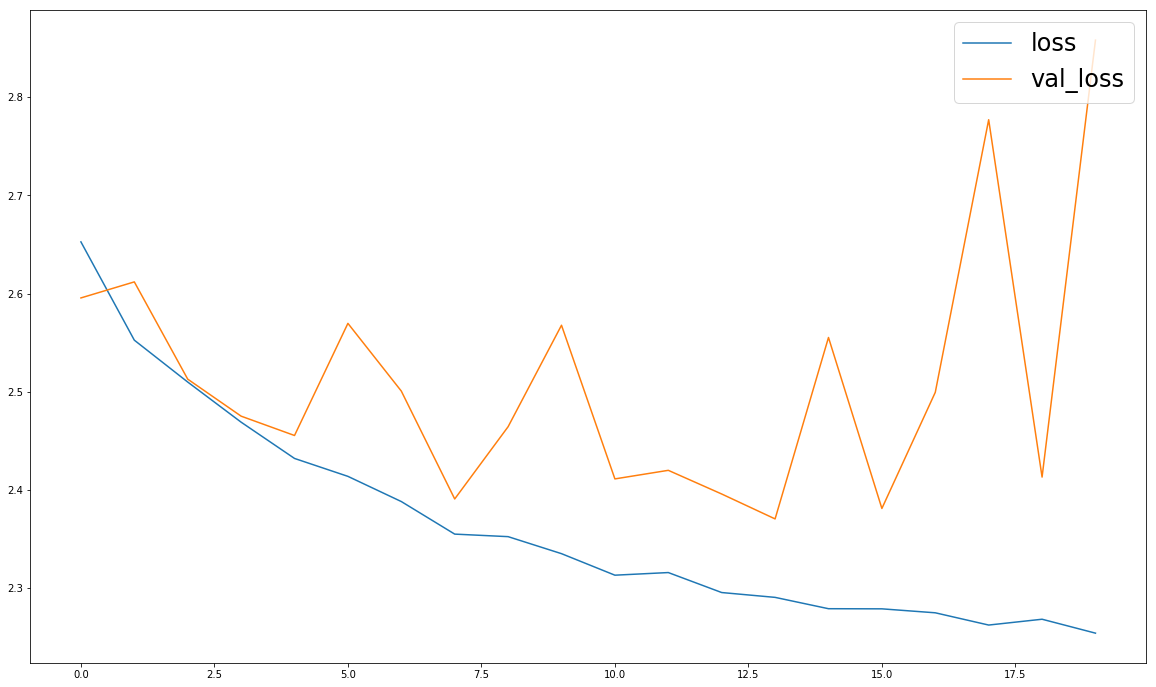

In [29]:
plt.figure(figsize=(20,12))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});

The validation loss has been decreasing at a similar pace as the training loss, indicating that our model has been learning effectively over the last 30 epochs. We could try to train longer and see if the validation loss can be decreased further. Once the validation loss stops decreasing for a couple of epochs in a row, that's when we will want to stop training. Our final weights will then be the weights of the epoch that had the lowest validation loss.

### 5. Make predictions

Now let's make some predictions on the validation dataset with the trained model. For convenience we'll use the validation generator which we've already set up above. Feel free to change the batch size.

You can set the `shuffle` option to `False` if you would like to check the model's progress on the same image(s) over the course of the training.

In [30]:
# 1: Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'processed_labels',
                                                  'filenames'},
                                         keep_images_without_gt=False)

In [31]:
# 2: Generate samples

batch_images, batch_labels, batch_filenames = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(batch_labels[i])

Image: ../Dataset/udacity_driving_datasets/1478900531489488683.jpg

Ground truth boxes:

[[  1  45 158 103 191]
 [  1  46 159 101 191]
 [  1 119 148 158 183]
 [  1 119 149 156 182]
 [  1 155 161 162 170]
 [  1 178 157 196 171]
 [  1 204 158 214 171]
 [  1 212 153 235 172]
 [  1 255 153 280 164]
 [  5 197  40 210  64]
 [  5 299 104 314 125]
 [  5 300 104 311 123]]


In [32]:
# 3: Make a prediction

y_pred = model.predict(batch_images)

Now let's decode the raw predictions in `y_pred`.

Had we created the model in 'inference' or 'inference_fast' mode, then the model's final layer would be a `DecodeDetections` layer and `y_pred` would already contain the decoded predictions, but since we created the model in 'training' mode, the model outputs raw predictions that still need to be decoded and filtered. This is what the `decode_detections()` function is for. It does exactly what the `DecodeDetections` layer would do, but using Numpy instead of TensorFlow (i.e. on the CPU instead of the GPU).

`decode_detections()` with default argument values follows the procedure of the original SSD implementation: First, a very low confidence threshold of 0.01 is applied to filter out the majority of the predicted boxes, then greedy non-maximum suppression is performed per class with an intersection-over-union threshold of 0.45, and out of what is left after that, the top 200 highest confidence boxes are returned. Those settings are for precision-recall scoring purposes though. In order to get some usable final predictions, we'll set the confidence threshold much higher, e.g. to 0.5, since we're only interested in the very confident predictions.

In [33]:
# 4: Decode the raw prediction `y_pred`

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.99 122.1  149.45 154.83 181.93]
 [  1.     0.98 177.84 154.45 199.41 173.25]
 [  1.     0.86 210.78 150.43 236.72 171.66]
 [  1.     0.72 187.91 157.82 200.59 170.23]
 [  1.     0.54  59.13 155.49  98.52 185.32]]


Finally, let's draw the predicted boxes onto the image. Each predicted box says its confidence next to the category name. The ground truth boxes are also drawn onto the image in green for comparison.

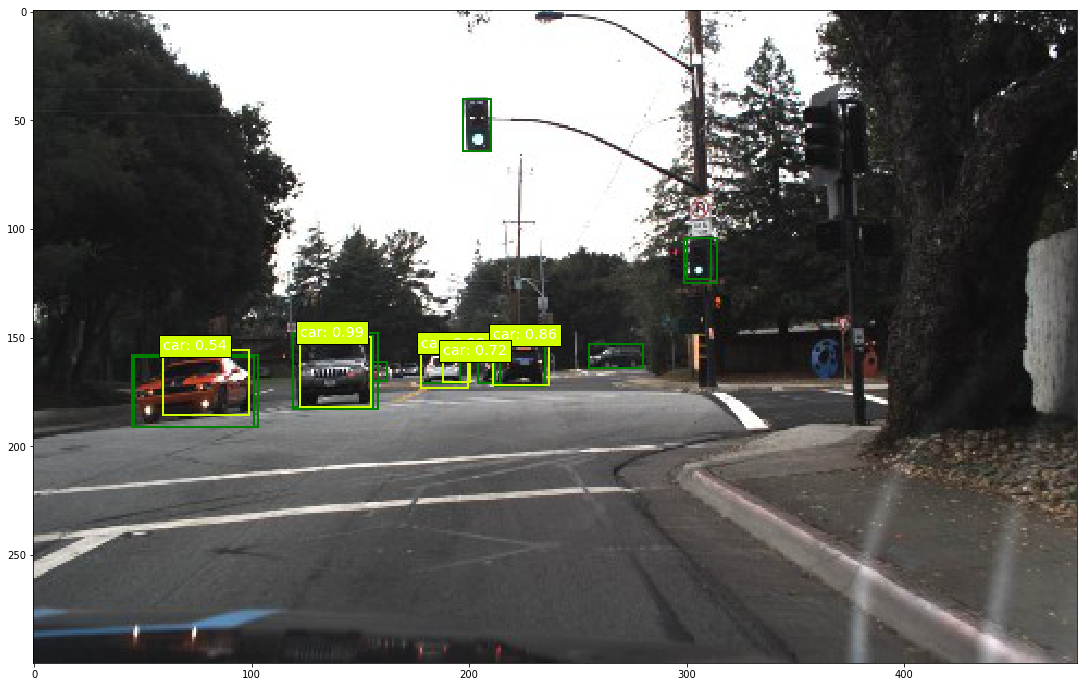

In [34]:
# 5: Draw the predicted boxes onto the image

plt.figure(figsize=(20,12))
plt.imshow(batch_images[i])

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist() # Set the colors for the bounding boxes
classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light'] # Just so we can print class names onto the image instead of IDs

# Draw the ground truth boxes in green (omit the label for more clarity)
for box in batch_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    #current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

# Draw the predicted boxes in blue
for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

### Comments: training from scratch

It took lots of time, but performance is not good compared with pre-trained model (SSD300, 512 using VOC or COCO). So I don't need to train from scratch anymore, and I will start fine-tuning for SSD512 from next week. 

Nobuto Yoshimura